## Exploring the data

Download the Wikipedia dataset + randomly sample sentences as input

In [1]:
# load dataset
from datasets import load_dataset

dataset = load_dataset("wiki_auto")

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No config specified, defaulting to: wiki_auto/auto
Reusing dataset wiki_auto (/n/home10/cyeh/.cache/huggingface/datasets/wiki_auto/auto/1.0.0/eeac705719dc9aa2ff180571dfed6c6649588ccdfde8d45a47d2e47e5c5b93af)
100%|██████████| 2/2 [00:00<00:00, 48.50it/s]


In [2]:
# remove data points with no examples
data = [dataset['part_1'][i]['normal']['normal_article_content']['normal_sentence'] for i in range(len(dataset['part_1'])) if len(dataset['part_1'][i]['normal']['normal_article_content']['normal_sentence']) != 0] 

In [3]:
# now see how many data points there are
data_len = len(data)
data_len

124913

In [4]:
# choose 1000 random data points to sample from
import random
num_examples = 1000
random.seed(10) # set seed
indices = random.sample(range(data_len), num_examples)
indices[:10]

[74894, 4270, 56215, 63250, 75771, 1944, 27013, 60631, 106603, 64395]

In [5]:
# get one sentence for each selected data point
sentences = []
for i in indices:
    # get all sentences associated with data point
    sentence_list = data[i]
    sentence = random.choice(sentence_list) # choose random sentence from list
    sentences.append(sentence)

sentences[:10]

['Synthpop band Freezepop have used it on stage.',
 "Plumb was awarded a knighthood in the Queen's Birthday Honours list in 1973.",
 'He read and memorized the entire Quran by the time he was nine years old.',
 "Some other yearly festivals are Paris-Plages, a festive event that lasts from mid-July to mid-August when the Right Bank of the Seine is converted into a temporary beach with sand, deck chairs and palm trees; Journées du Patrimoine, Fête de la Musique, Techno Parade, Nuit Blanche, Cinéma au clair de lune, Printemps des rues, Festival d'automne, and Fête des jardins.",
 'Despite this decision, many Church of the East Old Calendarists rejected the move so in an attempt to avert further dissent, the Holy Synod maintained that Easter would continue to be celebrated according to the Julian Calendar.',
 "On a difficult, slow pitch at Port Elizabeth, Australia struggled their way to 212 (7 wickets, 50 overs) against tight Sri Lankan bowling, thanks mainly to a great innings from A

### archive

In [2]:
# find where sentences are located
dataset['part_1'][0]['normal']['normal_article_content']['normal_sentence']

["Lata Mondal ( ; born: 16 January 1993, Dhaka) is a Bangladeshi cricketer who plays for the Bangladesh national women's cricket team.",
 'She is a right handed batter.',
 'Mondal was born on January 16, 1993 in Dhaka, Bangladesh.',
 "Mondal made her ODI career against the Ireland women's cricket team on November 26, 2011.",
 "Mondal made her T20I career against the Ireland women's cricket team on August 28, 2012.",
 "In October 2018, she was named in Bangladesh's squad for the 2018 ICC Women's World Twenty20 tournament in the West Indies.",
 "Mondal was a member of the team that won a silver medal in cricket against the China national women's cricket team at the 2010 Asian Games in Guangzhou, China."]

In [4]:
# see how many data points there are
data_len = len(dataset['part_1'])
data_len

125059

## Running BERT

Just seeing the basic output from BERT with 2 sentences

In [199]:
# load model
from transformers import BertTokenizer, BertModel, GPT2Model, GPT2Tokenizer
import torch
import numpy as np
from numpy.linalg import norm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA

In [286]:
# GPT check
model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_version)

# print(model.h[0].attn.c_attn.bias)

# check out parameters
# for name, param in model.named_parameters():                
#     print(name, param.size())

### Position experiment

In [287]:
# GPT
positions = model.wpe.weight 
unit_vecs = []
for pos in positions:
    pos = pos.detach().numpy()
    unit = pos / norm(pos)
    unit_vecs.append(unit)

In [291]:
new_norms_q = {}
new_norms_k = {}

# initialize list of norms
for layer in range(12):
    for head in range(12):
        new_norms_q[(layer, head)] = [qw_norms[layer * 12 + head]]
        new_norms_k[(layer, head)] = [kw_norms[layer * 12 + head]]
    
# compute new norms    
for pos in range(19):
    for layer in range(12):
        for head in range(12):
            q = get_weights(query_weights, layer, head)
            k = get_weights(key_weights, layer, head)
            
            q_transformed = unit_vecs[pos] @ q
            k_transformed = unit_vecs[pos] @ k

            norm_q = norm(q_transformed)
            norm_k = norm(k_transformed)

            new_norms_q[(layer, head)].append(norm_q)
            new_norms_k[(layer, head)].append(norm_k)

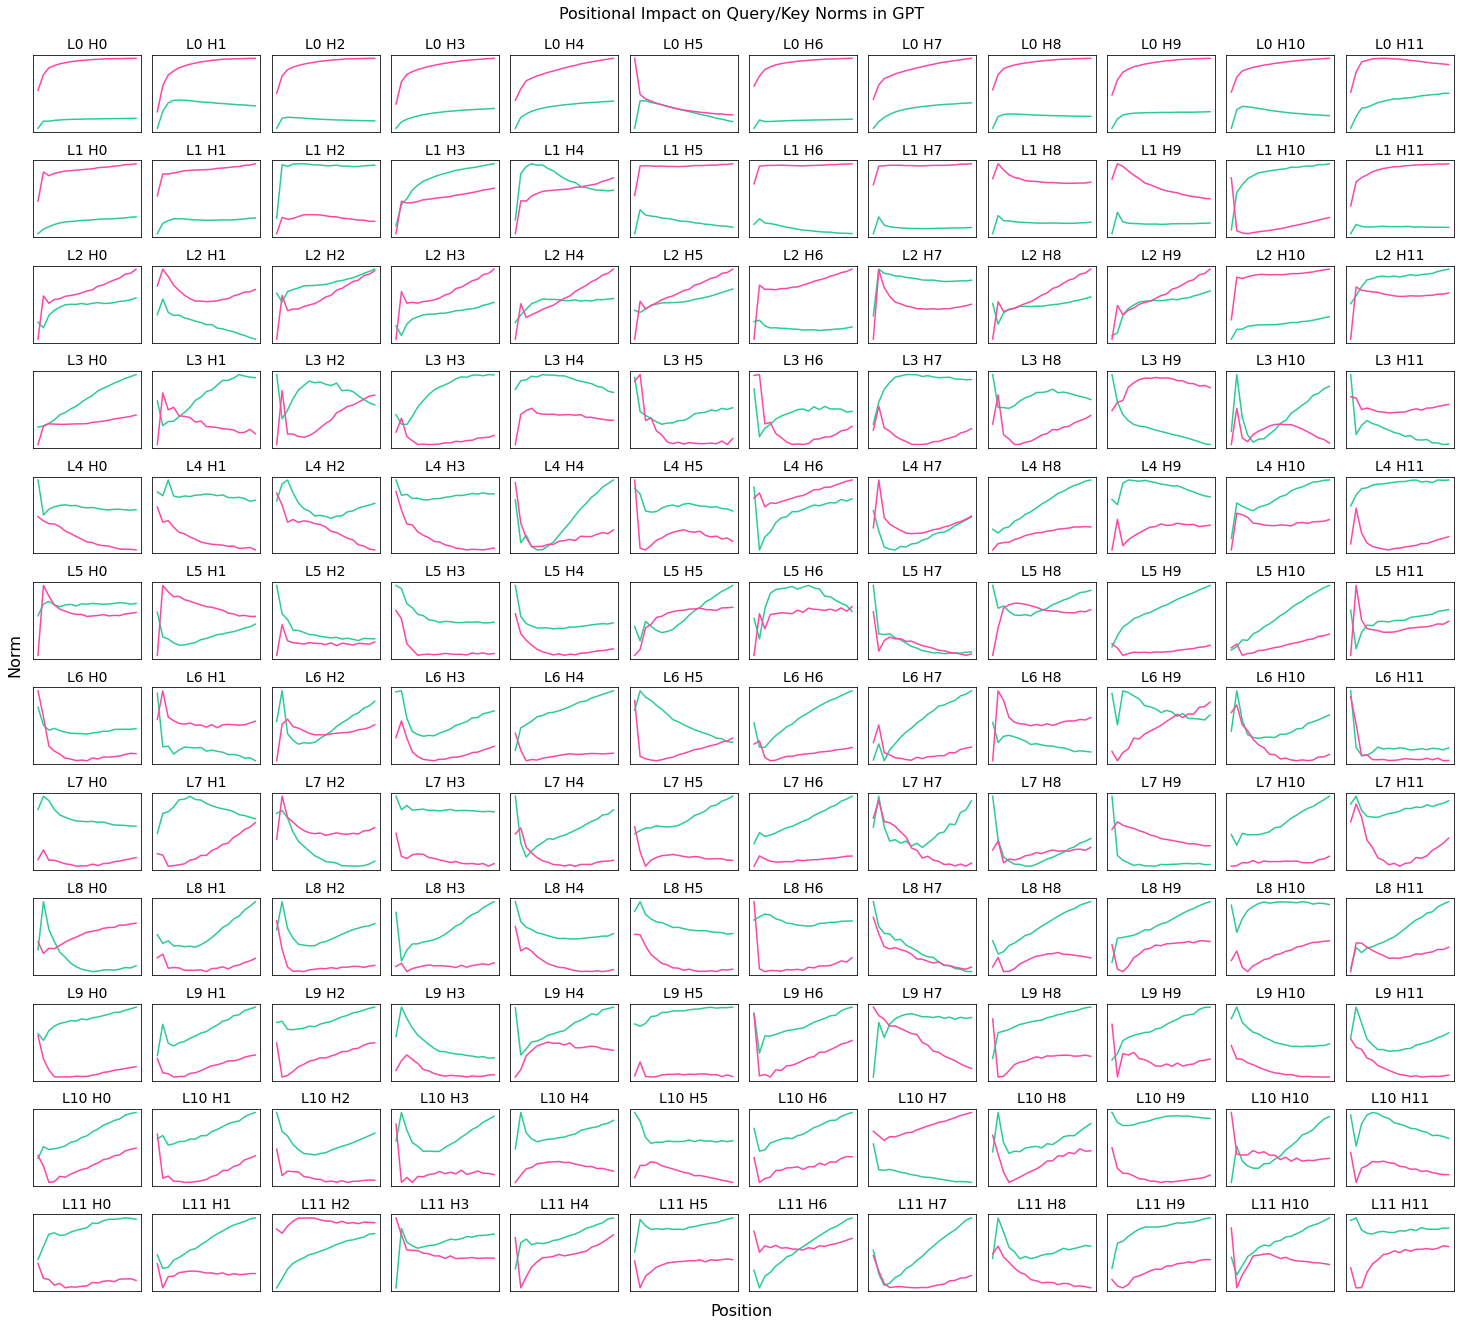

In [293]:
fig, axs = plt.subplots(12, 12)
for layer in range(12):
    for head in range(12):
        ax = axs[layer, head]
        ax.plot(new_norms_q[(layer, head)][1:], c='#2bcc91')
        ax.plot(new_norms_k[(layer, head)][1:], c='#fc47a5')
        ax.set_title("L{} H{}".format(layer, head), fontsize=14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.suptitle('Positional Impact on Query/Key Norms in GPT', fontsize=16, y=1)
fig.set_size_inches(20, 18)
fig.tight_layout(pad=0.8)
fig.text(0.5, -0.01, 'Position', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Norm', va='center', rotation='vertical', fontsize=16)
plt.show()

In [281]:
# BERT
positions = model.embeddings.position_embeddings.weight
unit_vecs = []
for pos in positions:
    pos = pos.detach().numpy()
    unit = pos / norm(pos)
    unit_vecs.append(unit)

In [282]:
new_norms_q = {}
new_norms_k = {}

# initialize list of norms
for layer in range(12):
    for head in range(12):
        new_norms_q[(layer, head)] = [bert_qw_norms[layer * 12 + head]]
        new_norms_k[(layer, head)] = [bert_kw_norms[layer * 12 + head]]
    
# compute new norms    
for pos in range(19):
    for layer in range(12):
        for head in range(12):
            q = get_weights(query_weights, layer, head)
            k = get_weights(key_weights, layer, head)
            
            q_transformed = unit_vecs[pos] @ q
            k_transformed = unit_vecs[pos] @ k

            norm_q = norm(q_transformed)
            norm_k = norm(k_transformed)

            new_norms_q[(layer, head)].append(norm_q)
            new_norms_k[(layer, head)].append(norm_k)

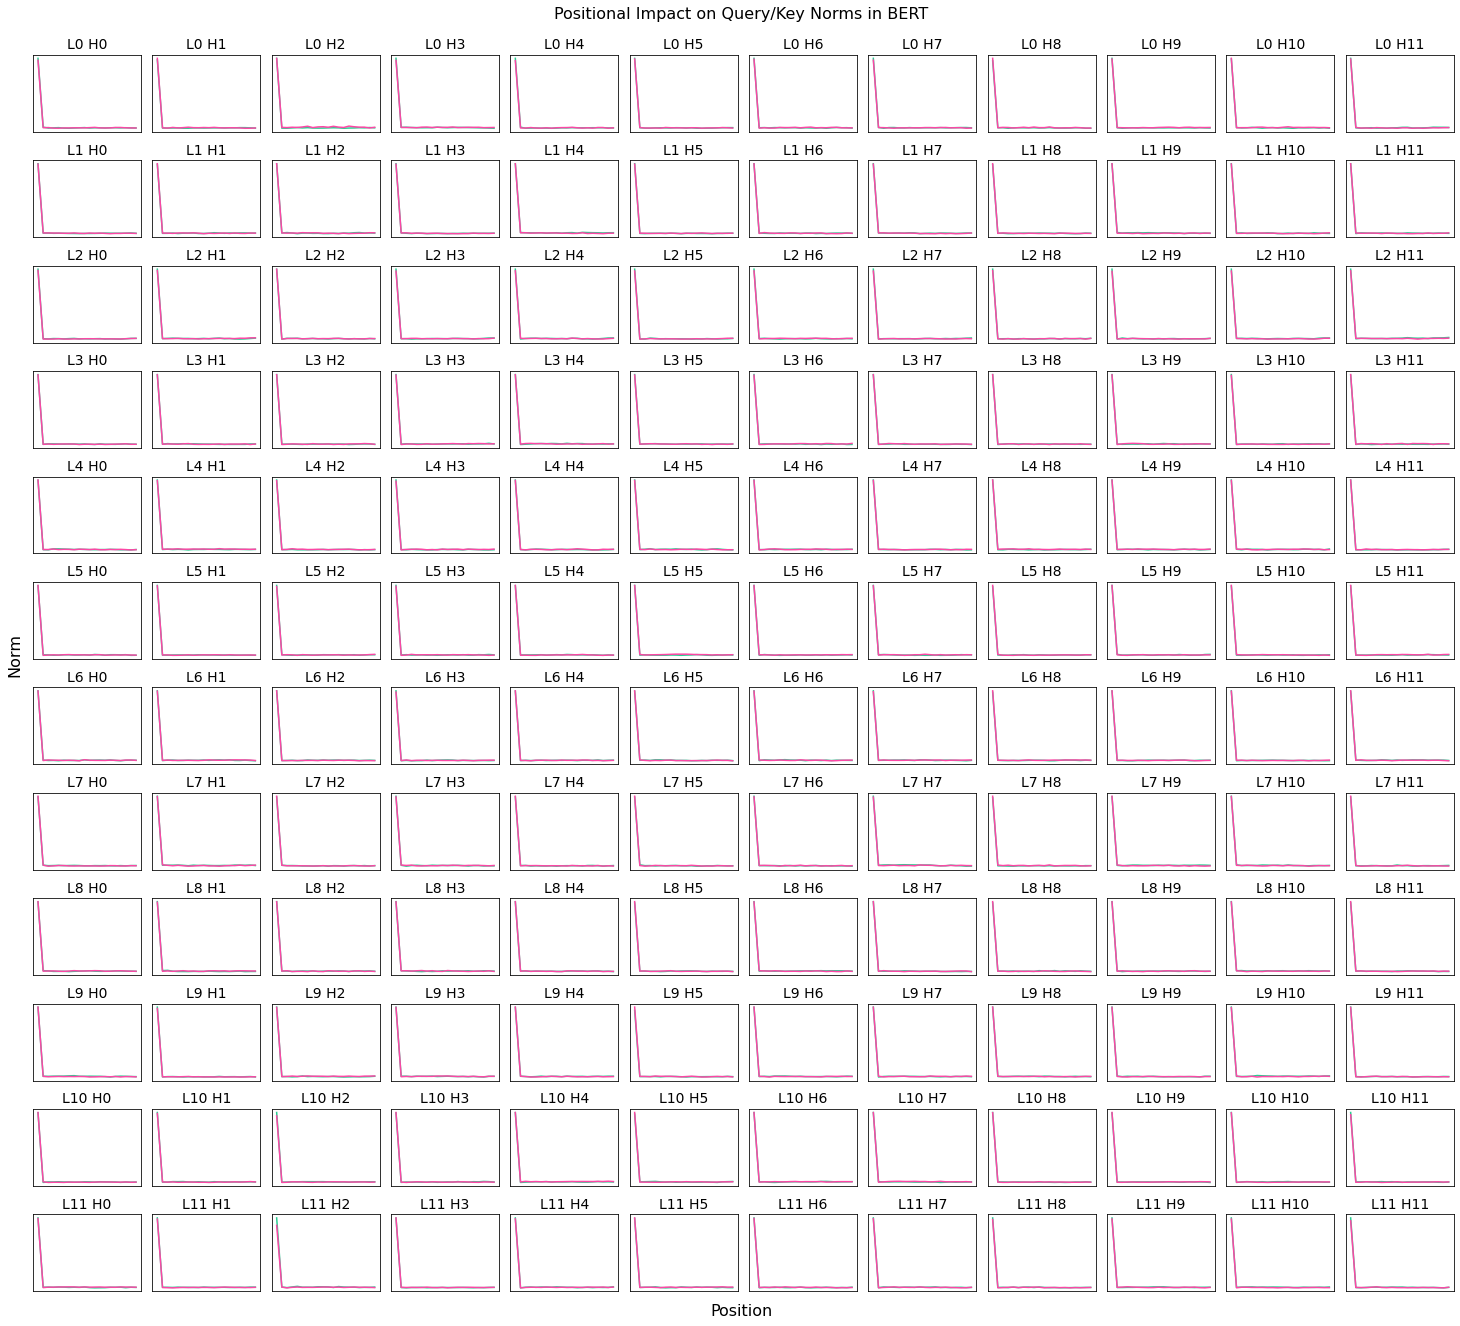

In [285]:
fig, axs = plt.subplots(12, 12)
for layer in range(12):
    for head in range(12):
        ax = axs[layer, head]
        ax.plot(new_norms_q[(layer, head)], c='#2bcc91')
        ax.plot(new_norms_k[(layer, head)], c='#fc47a5')
        ax.set_title("L{} H{}".format(layer, head), fontsize=14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.suptitle('Positional Impact on Query/Key Norms in BERT', fontsize=16, y=1)
fig.set_size_inches(20, 18)
fig.tight_layout(pad=0.8)
fig.text(0.5, -0.01, 'Position', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Norm', va='center', rotation='vertical', fontsize=16)
plt.show()

### GPT query/key weights

In [288]:
query_weights = []
key_weights = []

for i in range(12):
    weights = model.h[i].attn.c_attn.weight
    query, key, value = torch.split(weights, 768, dim=1)
    query_weights.append(query)
    key_weights.append(key)

In [241]:
# get key/query weights for a particular layer and head of GPT
def get_weights(weights, layer, head): 
    layer_weights = weights[layer]

    start = head * 64
    end = start + 64
    
#     h_start = head * 64
#     h_end = h_start + 64
    
    head_weights = [i[start:end].detach().numpy() for i in layer_weights] # only use corresponding 64 columns of matrix
    return head_weights

# qw = get_weights(query_weights, 0, 0)
# kw = get_weights(key_weights, 0, 0)
# print(len(qw))
# print(len(qw[0]))

In [289]:
qw_norms = []
kw_norms = []
cosine_sim = []

for layer in range(12):
    for head in range(12):
        qw = get_weights(query_weights, layer, head)
        kw = get_weights(key_weights, layer, head)
        
        qw_flat = np.asarray(qw).flatten()
        kw_flat = np.asarray(kw).flatten()
        
        # print(norm(qw_flat), norm(kw_flat))
        
        norm_q = norm(qw)
        norm_k = norm(kw)
        cosine = np.dot(qw_flat, kw_flat) / (norm_q * norm_k)
        
        qw_norms.append(norm_q)
        kw_norms.append(norm_k)
        cosine_sim.append(cosine)
        
        # print("Layer {}, Head {}: query norm = {:.4f}, key norm = {:.4f}, cosine sim = {:.4f}".format(layer, head, norm_q, norm_k, cosine))

In [290]:
avg_cos = sum(cosine_sim) / len(cosine_sim)
min_cos = min(cosine_sim)
max_cos = max(cosine_sim)
print("Average cosine sim = {:.4f}".format(avg_cos))
print("Min cosine sim = {:.4f}".format(min_cos))
print("Max cosine sim = {:.4f}".format(max_cos))

Average cosine sim = 0.0181
Min cosine sim = -0.6073
Max cosine sim = 0.8769


Text(0.5, 1.05, 'Cosine Similarity Between Query + Key Weights in GPT')

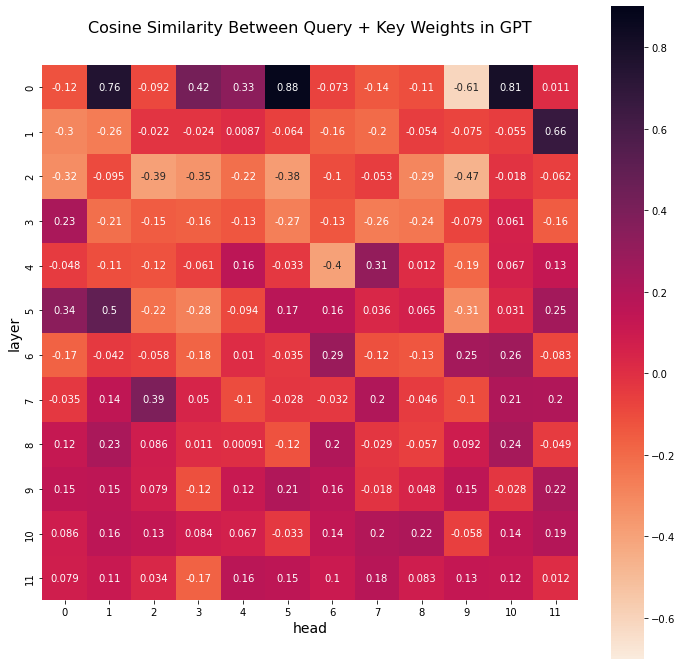

In [245]:
cosine_sim_reshape = np.reshape(cosine_sim, (12, 12))
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)
sns.heatmap(cosine_sim_reshape, annot=True, square=True, cmap = sns.cm.rocket_r, vmin=-0.7, vmax=0.9)
axs.set_xlabel('head', fontsize=14)
axs.set_ylabel('layer', fontsize=14)
axs.set_title('Cosine Similarity Between Query + Key Weights in GPT', fontsize=16, y=1.05)

In [246]:
# get norm differences
norm_differences = [abs(qw_norms[i] - kw_norms[i]) for i in range(len(qw_norms))]

In [247]:
stats.spearmanr(cosine_sim, norm_differences)[0]

-0.23058435817056508

In [248]:
avg_diff = sum(norm_differences) / len(norm_differences)
min_diff = min(norm_differences)
max_diff = max(norm_differences)
print("Average norm difference = {:.4f}".format(avg_diff))
print("Min norm difference = {:.4f}".format(min_diff))
print("Max norm difference = {:.4f}".format(max_diff))

Average norm difference = 2.3630
Min norm difference = 0.0415
Max norm difference = 21.7213


Text(0.5, 1.05, 'Norm Difference Between Query + Key Weights in GPT')

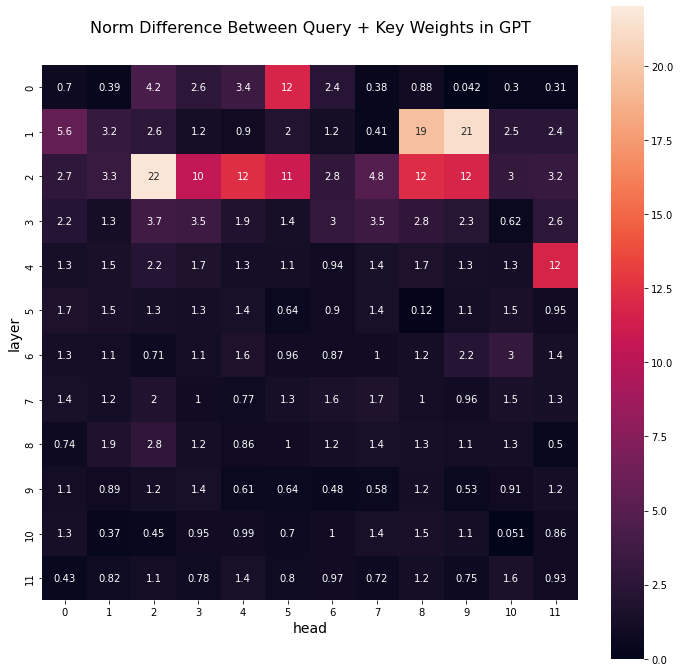

In [250]:
norms_reshape = np.reshape(norm_differences, (12, 12))
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)
sns.heatmap(norms_reshape, annot=True, square=True, vmin=0, vmax=22)
axs.set_xlabel('head', fontsize=14)
axs.set_ylabel('layer', fontsize=14)
axs.set_title('Norm Difference Between Query + Key Weights in GPT', fontsize=16, y=1.05)

### BERT query/key weights

In [ ]:
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

# check out parameters
for name, param in model.named_parameters():                
    print(name, param.size())

In [276]:
# get key + query weights
query_weights = []
key_weights = []

for i in range(12):
    query_weights.append(model.encoder.layer[i].attention.self.query.weight)
    key_weights.append(model.encoder.layer[i].attention.self.key.weight)
    
# print(len(query_weights))
# print(len(query_weights[0]))
# print(len(query_weights[0][:64]))
# print(query_weights[0][:64][:64])

In [253]:
# get key/query weights for a particular layer and head of BERT
# def get_weights(weights, layer, head): 
#     layer_weights = weights[layer]
#     start = layer * 64
#     end = start + 64
#     head_weights = [i[:64].detach().numpy() for i in layer_weights[start:end]] # only use first 64 columns of matrix
#     return head_weights

qw = get_weights(query_weights, 0, 0)
kw = get_weights(key_weights, 0, 0)
print(len(qw))
print(len(qw[0]))
# print(qw)
# print(kw)

768
64


In [277]:
bert_qw_norms = []
bert_kw_norms = []
bert_cosine_sim = []

for layer in range(12):
    for head in range(12):
        qw = get_weights(query_weights, layer, head)
        kw = get_weights(key_weights, layer, head)
        
        qw_flat = np.asarray(qw).flatten()
        kw_flat = np.asarray(kw).flatten()
        
        # print(norm(qw_flat), norm(kw_flat))
        
        norm_q = norm(qw)
        norm_k = norm(kw)
        cosine = np.dot(qw_flat, kw_flat) / (norm_q * norm_k)
        
        bert_qw_norms.append(norm_q)
        bert_kw_norms.append(norm_k)
        bert_cosine_sim.append(cosine)
        
        # print("Layer {}, Head {}: query norm = {:.4f}, key norm = {:.4f}, cosine sim = {:.4f}".format(layer, head, norm_q, norm_k, cosine))

In [278]:
avg_cos = sum(bert_cosine_sim) / len(bert_cosine_sim)
min_cos = min(bert_cosine_sim)
max_cos = max(bert_cosine_sim)
print("Average cosine sim = {:.4f}".format(avg_cos))
print("Min cosine sim = {:.4f}".format(min_cos))
print("Max cosine sim = {:.4f}".format(max_cos))

Average cosine sim = 0.0544
Min cosine sim = -0.1121
Max cosine sim = 0.2444


Text(0.5, 1.05, 'Cosine Similarity Between Query + Key Weights in BERT')

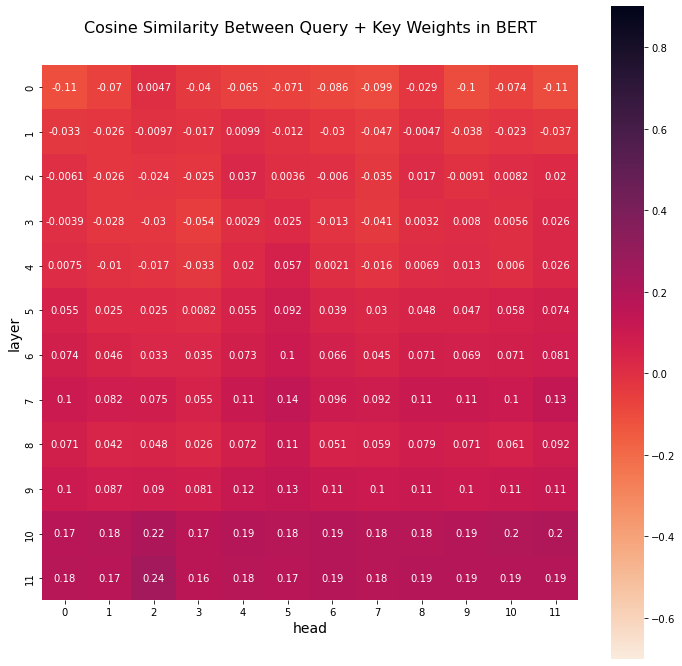

In [256]:
cosine_sim_reshape = np.reshape(bert_cosine_sim, (12, 12))
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)
sns.heatmap(cosine_sim_reshape, annot=True, square=True, cmap = sns.cm.rocket_r, vmin=-0.7, vmax=0.9)
axs.set_xlabel('head', fontsize=14)
axs.set_ylabel('layer', fontsize=14)
axs.set_title('Cosine Similarity Between Query + Key Weights in BERT', fontsize=16, y=1.05)

In [257]:
# get norm differences
bert_norm_differences = [abs(bert_qw_norms[i] - bert_kw_norms[i]) for i in range(len(bert_qw_norms))]

In [258]:
stats.spearmanr(bert_cosine_sim, bert_norm_differences)[0]

-0.00895024515714171

In [259]:
avg_diff = sum(bert_norm_differences) / len(norm_differences)
min_diff = min(bert_norm_differences)
max_diff = max(bert_norm_differences)
print("Average norm difference = {:.4f}".format(avg_diff))
print("Min norm difference = {:.4f}".format(min_diff))
print("Max norm difference = {:.4f}".format(max_diff))

Average norm difference = 0.1092
Min norm difference = 0.0013
Max norm difference = 1.1649


Text(0.5, 1.05, 'Norm Difference Between Query + Key Weights in BERT')

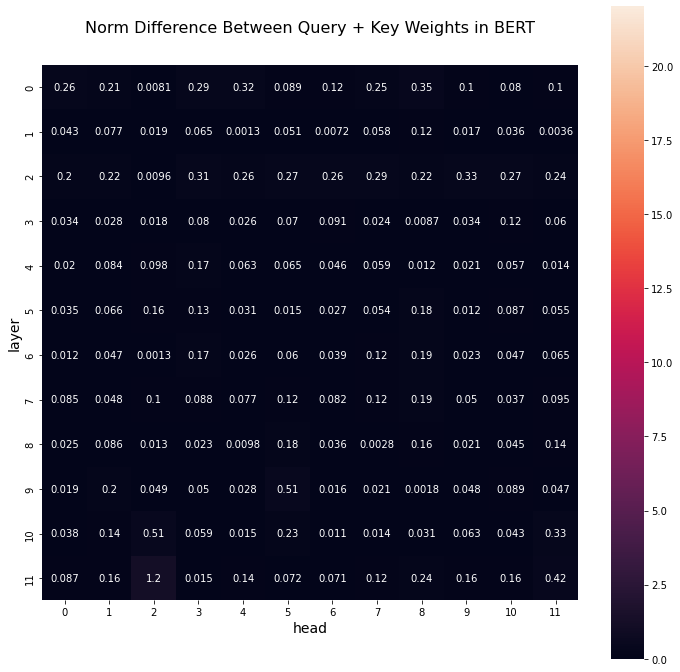

In [260]:
norms_reshape = np.reshape(bert_norm_differences, (12, 12))
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)
sns.heatmap(norms_reshape, annot=True, square=True, vmin=0, vmax=22)
axs.set_xlabel('head', fontsize=14)
axs.set_ylabel('layer', fontsize=14)
axs.set_title('Norm Difference Between Query + Key Weights in BERT', fontsize=16, y=1.05)

#### translation

In [ ]:
# translate queries/keys

new_queries = []
new_keys = []
for layer in range(12):
    qw = get_weights(query_weights, layer)
    kw = get_weights(key_weights, layer)
    
    layer_q = []
    layer_k = []
    for head in range(12):
        residuals = get_residual(layer, head, all_embeddings)
        head_q = []
        head_k = []
        
        for i in range(5021):
            resid = residuals[i]
            pos = pos_embeddings[i]
            
            new_q = (resid - pos) @ qw
            new_k = (resid - pos) @ kw
            
            head_q.append(new_q)
            head_k.append(new_k)
        
        layer_q.append(head_q)
        layer_k.append(head_k)
    new_queries.append(layer_q)
    new_keys.append(layer_k)
        

In [33]:
# testing output
print(len(new_queries))
print(len(new_queries[0]))
print(len(new_queries[0][0]))
print(len(new_queries[0][0][0]))
print(new_queries[0][0][0])

1
1
5021
64
[-0.1369884  -0.14854914 -0.08596523 -0.12712175  0.01007286  0.01294856
  0.00599119 -0.08905892 -0.16988814 -0.03032058 -0.39133036 -0.00748111
 -0.20425329 -0.02023375 -0.14363326  0.19130732 -0.03655571  0.37733266
  0.02783615 -0.45427683  0.17809579  0.1079484  -0.2714282  -0.32305443
  0.13175473 -0.2077744  -0.06739779  0.14300585  0.08777865 -0.06469515
  0.10473183 -0.16862983 -0.26604837 -0.08875294  0.04311044  0.17097725
  0.1016324  -0.0418257  -0.08671996 -0.1543017  -0.19681175 -0.23717856
 -0.06384265 -0.24072504 -0.01807201  0.16076753 -0.01942985  0.06221947
 -0.06492541 -0.3209853   0.00956208 -0.08334925 -0.07177339 -0.30399776
 -0.08219443  0.02683333  0.02971542 -0.03185933 -0.05103403 -0.22944306
 -0.00583357  0.18605001 -0.48215964  0.2982958 ]


In [105]:
print(sent_offset[:166])

[0, 13, 33, 52, 151, 195, 263, 306, 327, 341, 356, 379, 404, 430, 454, 485, 514, 544, 561, 594, 617, 645, 692, 725, 756, 773, 817, 870, 892, 902, 943, 958, 980, 1008, 1040, 1066, 1084, 1126, 1142, 1196, 1214, 1287, 1318, 1346, 1375, 1387, 1404, 1435, 1453, 1467, 1498, 1520, 1538, 1555, 1593, 1616, 1639, 1668, 1686, 1717, 1737, 1767, 1805, 1829, 1869, 1916, 1946, 1982, 2000, 2037, 2122, 2153, 2172, 2187, 2221, 2255, 2287, 2320, 2343, 2370, 2447, 2466, 2479, 2507, 2528, 2572, 2590, 2615, 2632, 2679, 2710, 2725, 2743, 2772, 2814, 2870, 2881, 2920, 2941, 2964, 3003, 3038, 3053, 3091, 3127, 3156, 3225, 3261, 3309, 3328, 3379, 3431, 3458, 3476, 3502, 3529, 3561, 3596, 3616, 3628, 3682, 3694, 3713, 3737, 3757, 3777, 3841, 3859, 3882, 3909, 3937, 3990, 4007, 4028, 4051, 4067, 4101, 4122, 4141, 4166, 4183, 4232, 4286, 4355, 4375, 4414, 4446, 4486, 4522, 4531, 4549, 4561, 4597, 4608, 4634, 4697, 4720, 4752, 4794, 4815, 4867, 4884, 4913, 4930, 4961, 4990]


In [106]:
import numpy as np
from scipy.special import softmax

In [123]:
# new attention too
new_attention = []
sent_offset_short = sent_offset[:166]

for layer in range(12):
    layer_a = []
    for head in range(12):
        queries = new_queries[layer][head]
        keys = new_keys[layer][head]
        head_a = []
        for i in range(len(sent_offset_short)):
            offset = sent_offset_short[i]
            sent_end = sent_offset_short[i + 1] if (i < len(sent_offset_short) - 1) else 5021
            sent_length = sent_end - offset

            for q in range(sent_length):
                qt = queries[q + offset] 
                sent_a = []
                for k in range(sent_length): 
                    kt = keys[k + offset]
                    dp = np.dot(qt, kt) / 8
                    sent_a.append(dp)
                sent_a = softmax(sent_a)
                head_a.append(sent_a)
        layer_a.append(head_a)
    new_attention.append(layer_a)

In [132]:
# checking output
print(len(new_attention))
print(len(new_attention[0]))
print(len(new_attention[0][0]))
print(len(new_attention[0][0][0]))
print(new_attention[3][3][100])

12
12
5021
13
[0.01045118 0.01052404 0.01071847 0.01013402 0.01048055 0.01107781
 0.01314685 0.01075095 0.0104721  0.01204513 0.01100142 0.01130517
 0.00928909 0.0103305  0.00916803 0.01000367 0.01006789 0.01032908
 0.01239239 0.01011021 0.01071867 0.01061799 0.01153235 0.00939029
 0.00989751 0.01048117 0.01023524 0.01214973 0.01131627 0.01109165
 0.01043124 0.01046258 0.00958865 0.00985062 0.00980618 0.01050019
 0.01020141 0.00887739 0.0095902  0.00868723 0.00927218 0.00989788
 0.00932802 0.00894833 0.00924289 0.00891931 0.00894367 0.0082284
 0.00886973 0.0099549  0.00967301 0.00897081 0.01015975 0.00923906
 0.00918916 0.00915036 0.0076304  0.00856072 0.00956672 0.00937582
 0.00961924 0.01042269 0.01046611 0.01028361 0.009815   0.00989754
 0.00964329 0.01021381 0.0098736  0.00980804 0.01010115 0.01056193
 0.00971507 0.00919799 0.01083678 0.00987425 0.00944887 0.01141155
 0.01116812 0.00984293 0.01038405 0.01027914 0.01001089 0.01015224
 0.0110975  0.01030683 0.01035277 0.01020298 0.01

### archive

In [23]:
# adapted from bertviz: github.com/jessevig/bertviz
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "This is a test"
sentence_b = "Hi my name is Catherine"
inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
output = model(input_ids, token_type_ids=token_type_ids)
attention = output[-1]
# sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [92]:
word_embeddings = output[0]
print(word_embeddings.shape)

torch.Size([1, 6, 768])


In [5]:
# check out parameters
for name, param in model.named_parameters():                
    print(name, param.size())

embeddings.word_embeddings.weight torch.Size([30522, 768])
embeddings.position_embeddings.weight torch.Size([512, 768])
embeddings.token_type_embeddings.weight torch.Size([2, 768])
embeddings.LayerNorm.weight torch.Size([768])
embeddings.LayerNorm.bias torch.Size([768])
encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
encoder.layer.0.attention.self.query.bias torch.Size([768])
encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
encoder.layer.0.attention.self.key.bias torch.Size([768])
encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
encoder.layer.0.attention.self.value.bias torch.Size([768])
encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
encoder.layer.0.attention.output.dense.bias torch.Size([768])
encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])
encoder.layer.0.attention.output.LayerNorm.bias torch.Size([768])
encoder.layer.0.intermediate.dense.weight torch.Size([3072, 768])
encoder.layer.0.inter

In [42]:
print(model.encoder.layer[0].attention.self.query)

torch.Size([768, 768])


In [6]:
print(model.encoder.layer[11].attention.self.query.bias)

Parameter containing:
tensor([ 5.0130e-02,  1.1887e-01,  2.1868e-01,  8.7210e-02, -2.0477e-01,
         2.2648e-01, -3.4360e-01,  6.4057e-02, -4.1554e-01,  1.1557e-01,
         2.8522e-01, -1.0724e-01,  2.1037e-01,  6.5960e-02, -8.9728e-02,
        -6.1263e-02,  1.1344e-01, -1.9265e-01, -1.2109e-02, -2.4905e-01,
         7.1558e-02, -2.0746e-01, -1.8167e-01, -1.9616e-02,  5.7593e-02,
        -4.0425e-02,  3.1487e-01, -1.6641e-01,  3.6615e-01,  2.8458e-02,
        -8.9834e-02, -4.3720e-02, -1.2218e-01,  1.1063e-01,  4.6565e-02,
         5.6489e-02,  2.5875e-01,  1.0859e-01, -2.2724e-01, -1.5846e-01,
        -2.0762e-01, -2.8562e-01, -1.6824e-01,  1.7382e-01,  2.8304e-02,
        -8.5946e-02, -1.2882e-01, -3.9624e-05,  1.3995e-01, -1.4809e-01,
        -1.4983e-01,  8.0181e-02, -2.4638e-01,  1.3984e-01, -4.8627e-01,
        -3.8021e-02,  7.8774e-02, -5.4215e-01,  1.8015e-01, -2.4764e-01,
        -8.2056e-02,  2.0403e-01, -1.2871e-01,  1.7048e-01,  3.3818e-01,
        -5.3207e-01,  2.6975e

In [35]:
print(tokens)
print(len(tokens))
print(len(embeddings)) # num layers
print(len(embeddings[0][0])) # num tokens
print(len(embeddings[0][0][0])) # num tokens
print(embeddings[0][0][0][0]) # num tokens

['[CLS]', 'plum', '##b', 'was', 'awarded', 'a', 'knight', '##hood', 'in', 'the', 'queen', "'", 's', 'birthday', 'honours', 'list', 'in', '1973', '.', '[SEP]']
20
12
12
20
tensor([0.0380, 0.0188, 0.0278, 0.0264, 0.0301, 0.1063, 0.0305, 0.0245, 0.0633,
        0.0966, 0.0320, 0.0324, 0.0258, 0.0352, 0.0172, 0.0413, 0.0653, 0.0295,
        0.0721, 0.1866], grad_fn=<SelectBackward0>)


In [20]:
# check out output
print(sentence_a)
print(sentence_b)
print(tokens)
print(len(tokens))

In the early 1970s, Edgar Winter often performed with keyboards slung around his neck, but they were not technically keytars because they had no "neck"; he actually used an ARP 2600 keyboard and a lightweight Univox electronic piano with shoulder straps added.
As of July 2012, Plumb's entry in the register of interests listed his only remunerated employment/profession as 'farming', despite his involvement with the Brussels-based lobbying firm Alber and Geiger since 2007.
['[CLS]', 'in', 'the', 'early', '1970s', ',', 'edgar', 'winter', 'often', 'performed', 'with', 'keyboards', 'slung', 'around', 'his', 'neck', ',', 'but', 'they', 'were', 'not', 'technically', 'key', '##tar', '##s', 'because', 'they', 'had', 'no', '"', 'neck', '"', ';', 'he', 'actually', 'used', 'an', 'ar', '##p', '260', '##0', 'keyboard', 'and', 'a', 'lightweight', 'un', '##ivo', '##x', 'electronic', 'piano', 'with', 'shoulder', 'straps', 'added', '.', '[SEP]', 'as', 'of', 'july', '2012', ',', 'plum', '##b', "'", 's', 

In [43]:
print(len(attention)) # corresponds to 12 layers of model
print(len(attention[0][0])) # 12 attention heads (e.g., different attention patterns/mechanisms)
print(attention[0][0][0].shape) # size of attention matrix (at each head)

12
12
torch.Size([104, 104])


In [48]:
print(sum(attention[0][0][0][0])) # normalized, attention weights for each token must sum to 1

tensor(1., grad_fn=<AddBackward0>)


## Masking

In [ ]:
from transformers import pipeline
import random
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
unmasker = pipeline('fill-mask', model=model_version)

random.seed(10) # set seed

# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)

new_sentences = []
replaced = []

for sent in sentences:
    encoded = tokenizer(sent, return_tensors='pt')
    tokens = encoded['input_ids'][0]
    num_tokens = len(tokens) - 3 # don't include cls/sep
    mask_ind = random.randint(0, num_tokens) + 1
    old_token = ''.join(tokenizer.decode(tokens[mask_ind]).split(" ")) # save old token
    
    tokens[mask_ind] = 103 # replace randomly selected token with mask

    tokens = tokens[1:-1] # remove extra cls and sep
    new_sent = tokenizer.decode(tokens) # convert back to string
#     results = unmasker(new_sent)
#     final_res = results[0]['sequence'] # new sentence
#     new_token = results[0]['token_str'] # new token
    
#     if old_token == new_token:
#         final_res = results[1]['sequence'] # new sentence
#         new_token = results[1]['token_str'] # new token
#     replaced.append({"index": mask_ind, "old": old_token, "new": new_token}) # save to list
    replaced.append({"index": mask_ind, "old": old_token})
    
    # new_sentences.append(final_res)
    new_sentences.append(new_sent)
    # break
    
print(new_sentences[:10])
print(replaced[:10])

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_version)

for s1, s2 in zip(sentences, new_sentences):
    encoded1 = tokenizer(s1, return_tensors='pt')
    tokens1 = encoded1['input_ids'][0]
    encoded2 = tokenizer(s2, return_tensors='pt')
    tokens2 = encoded2['input_ids'][0]
    if len(tokens1) != len(tokens2):
        # print(tokens1)
        # print(tokens2)
        print(len(tokens1), s1)
        print(len(tokens2), s2)
        print("\n")

In [38]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

## Getting Q, K vectors

Follow Jesse Vig's method of extracting query + key info

In [6]:
# import methods from bertviz
from bertviz import neuron_view
import numpy as np

In [7]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer, GPT2Model, GPT2Tokenizer
import random
import string

# BERT
# model_type = 'bert'
# model_version = 'bert-base-uncased'
# model = BertModel.from_pretrained(model_version, output_attentions=True)
# tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)

# GPT
model_type = 'gpt2'
model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_version, do_lower_case=True)

sentences_test = sentences[:10] # small sample to test out code with
num_heads = 12
num_layers = 12

# master dictionary for all values
attn_dict = {'left_text': [], 
             'right_text': [], 
             'positions': [],
             'normalized_positions': [],
             'sentences': [],
             'tokenized_sentences': [],
             'queries': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)], 
             'keys': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)],
             'attn': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)],
             'dot_prod': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)]}

for s in sentences:
    # call method from bertviz to get attention info
    s_dict = neuron_view.get_attention(model, model_type, tokenizer, s, include_queries_and_keys=True)['all']
    
    # append to master dictionary
    tokens = s_dict['left_text']
    attn_dict['left_text'].extend(tokens)
    attn_dict['right_text'].extend(s_dict['right_text'])
    
    for index in range(len(tokens)): # save position of token and tokenized sentences too
        attn_dict['positions'].append(index)
        attn_dict['normalized_positions'].append(index / (len(tokens) - 1))
        attn_dict['sentences'].append(s)
        attn_dict['tokenized_sentences'].append(' '.join(tokens))
        
    for i in range(num_heads): # updating cumulative q/k vectors + attn
        for j in range(num_layers):
            q = attn_dict['queries'][i][j]
            k = attn_dict['keys'][i][j]
            a = attn_dict['attn'][i][j]
            d = attn_dict['dot_prod'][i][j]
            
            if len(q) == 1: # on first round, need to empty list (random string was placeholder)
                q.clear()
            query = s_dict['queries'][i][j]
            q.extend(query)
            np_query = np.array(query)
            
            if len(k) == 1:
                k.clear()
            key = s_dict['keys'][i][j]
            k.extend(key)
            np_key = np.array(key)
            
            if len(a) == 1:
                a.clear()
            a.extend(s_dict['attn'][i][j])
            
            if len(d) == 1:
                d.clear()
            dp = np.dot(np_query, np_key.transpose())
            
            d.extend(dp)

In [38]:
import pickle
# save dictionary to pickle file
with open('attn_dict_new.p', 'wb') as file:
    pickle.dump(attn_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

### Trying out attention plot generation

In [14]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer

## NEURON VIEW
model_type = 'bert'
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)

sentence_a = "This is a test"

# generate html for attention view
html = neuron_view.show(model, model_type, tokenizer, sentence_a, sentence_b=None, display_mode='dark', layer=0, head=0, html_action='return')

with open('att.html', "w") as file: # save html to file
    file.write(html.data)

In [20]:
## HEAD VIEW
from transformers import BertTokenizer, BertModel
from bertviz import head_view

model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
# sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

html = head_view(attention, tokens, layer=0, heads=[0], include_layers=[0], html_action='return') # generate html

with open('att2.html', "w") as file: # save html to file
    file.write(html.data)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### checking output

In [8]:
print(len(attn_dict['left_text']))
print(attn_dict['left_text'][:20])

print(len(attn_dict['positions']))
print(attn_dict['positions'][:20])

print(len(attn_dict['sentences']))
print(attn_dict['sentences'][:20])

print(len(attn_dict['tokenized_sentences']))
print(attn_dict['tokenized_sentences'][:20])

28679
['Syn', 'th', 'pop', ' band', ' Free', 'z', 'ep', 'op', ' have', ' used', ' it', ' on', ' stage', '.', 'Pl', 'umb', ' was', ' awarded', ' a', ' kn']
28679
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 1, 2, 3, 4, 5]
28679
['Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', 'Synthpop band Freezepop have used it on stage.', "Plumb was awarded a knighthood in the Queen's Birthday Honours lis

In [10]:
# checking
print(attn_dict['tokenized_sentences'][0])
print(len(attn_dict['tokenized_sentences'][0].split()))

print("\n" + str(len(attn_dict['attn'])))
print(len(attn_dict['attn'][0]))
print(len(attn_dict['attn'][0][0]))
print(len(attn_dict['attn'][0][0][14]))

Syn th pop  band  Free z ep op  have  used  it  on  stage .
14

12
12
28679
19


In [12]:
print(attn_dict['left_text']) # see output for smaller sample

['[CLS]', 'synth', '##pop', 'band', 'freeze', '##pop', 'have', 'used', 'it', 'on', 'stage', '.', '[SEP]', '[CLS]', 'plum', '##b', 'was', 'awarded', 'a', 'knight', '##hood', 'in', 'the', 'queen', "'", 's', 'birthday', 'honours', 'list', 'in', '1973', '.', '[SEP]', '[CLS]', 'he', 'read', 'and', 'memo', '##rized', 'the', 'entire', 'quran', 'by', 'the', 'time', 'he', 'was', 'nine', 'years', 'old', '.', '[SEP]', '[CLS]', 'some', 'other', 'yearly', 'festivals', 'are', 'paris', '-', 'pl', '##ages', ',', 'a', 'fest', '##ive', 'event', 'that', 'lasts', 'from', 'mid', '-', 'july', 'to', 'mid', '-', 'august', 'when', 'the', 'right', 'bank', 'of', 'the', 'seine', 'is', 'converted', 'into', 'a', 'temporary', 'beach', 'with', 'sand', ',', 'deck', 'chairs', 'and', 'palm', 'trees', ';', 'jo', '##urne', '##es', 'du', 'pat', '##rim', '##oin', '##e', ',', 'fe', '##te', 'de', 'la', 'musique', ',', 'techno', 'parade', ',', 'nu', '##it', 'blanche', ',', 'cinema', 'au', 'clair', 'de', 'lu', '##ne', ',', 'pri

In [13]:
print(attn_dict['queries'][0][0][0])

[0.7089897394180298, -0.15323276817798615, -0.032386213541030884, 0.6158232092857361, -0.5596219897270203, -0.011101782321929932, 0.49646368622779846, -0.2839057445526123, -0.280123233795166, 0.3392143249511719, -0.29341602325439453, -0.17901477217674255, 0.8661503195762634, 0.022664345800876617, 0.7185714244842529, 0.34335076808929443, 0.01236235722899437, 0.7172088027000427, 0.32118237018585205, -2.046285629272461, -0.45574820041656494, 0.1372668296098709, 0.7596356868743896, 0.7640693187713623, -0.485566645860672, -0.5769205093383789, 0.25511786341667175, 1.1232143640518188, 0.29362547397613525, 1.985978364944458, 0.7019451856613159, -0.509594202041626, 0.6935110688209534, 0.03461742401123047, 0.2705886960029602, -0.9227743148803711, 0.2610951066017151, -0.030122220516204834, 0.5660263895988464, -0.2227349430322647, -0.168127179145813, -0.7366577386856079, 0.3504031300544739, 0.6493116617202759, -1.475498080253601, -0.19565290212631226, 0.21594813466072083, -0.4464242160320282, -0.1

In [11]:
# checking to make sure things look right
print(len(attn_dict['left_text'])) # num tokens
      
print(len(attn_dict['queries'])) # 12 layers
print(len(attn_dict['queries'][0])) # 12 heads
print(len(attn_dict['queries'][0][0])) # source sequence length (number of tokens)
print(len(attn_dict['queries'][0][0][0])) # vector size

28679
12
12
28679
64


In [12]:
print(len(attn_dict['right_text'])) # num tokens
      
print(len(attn_dict['keys'])) # 12 layers
print(len(attn_dict['keys'][0])) # 12 heads
print(len(attn_dict['keys'][0][0])) # source sequence length (number of tokens)
print(len(attn_dict['keys'][0][0][0])) # vector size

28679
12
12
28679
64


### archive

In [11]:
# this output does include query and key vectors
output = model(input_ids, token_type_ids=token_type_ids)

In [103]:
"""
from bertviz documentation:
    get_attention method should return:
      Dictionary of attn representations with the structure:
      {
        'all': All attention (source = AB, target = AB)
        'aa': Sentence A self-attention (source = A, target = A) (if sentence_b is not None)
        'bb': Sentence B self-attention (source = B, target = B) (if sentence_b is not None)
        'ab': Sentence A -> Sentence B attention (source = A, target = B) (if sentence_b is not None)
        'ba': Sentence B -> Sentence A attention (source = B, target = A) (if sentence_b is not None)
      }
      where each value is a dictionary:
      {
        'left_text': list of source tokens, to be displayed on the left of the vis
        'right_text': list of target tokens, to be displayed on the right of the vis
        'attn': list of attention matrices, one for each layer. Each has shape [num_heads, source_seq_len, target_seq_len]
        'queries' (optional): list of query vector arrays, one for each layer. Each has shape (num_heads, source_seq_len, vector_size)
        'keys' (optional): list of key vector arrays, one for each layer. Each has shape (num_heads, target_seq_len, vector_size)
      }
"""
print(len(attn_dict))

4


## Context Embeddings

In [110]:
# adapted from bertviz: github.com/jessevig/bertviz
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

all_embeddings = []

for sent in sentences:
    inputs = tokenizer.encode_plus(sent, return_tensors='pt')
    input_ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    output = model(input_ids, token_type_ids=token_type_ids)
    embeddings = output[0]
    for e in embeddings[0]:
        all_embeddings.append(e)
    
    # break
    
print(len(all_embeddings))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


30070


In [111]:
all_embeddings = all_embeddings[:5021] # only take first 5021 tokens
print(len(all_embeddings))

5021


### archive

In [ ]:
!pip install flair

In [85]:
from flair.data import Sentence
from flair.embeddings import BertEmbeddings
bert_embedding = BertEmbeddings()

embeddings = []

for sent in sentences:
    s = Sentence(sent)
    bert_embedding.embed(s)
    for token in s:
       embeddings.append(token.embedding)
    # break
    
print(len(embeddings))

<ipython-input-85-8cf289f84c96>:3: DeprecationWarning:

Call to deprecated method __init__. (Use 'TransformerWordEmbeddings' for all transformer-based word embeddings) -- Deprecated since version 0.4.5.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

24592


## Residuals

In [14]:
# adapted from bertviz: github.com/jessevig/bertviz
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

all_embeddings = [[] for i in range(12)]

for sent in sentences:
    inputs = tokenizer.encode_plus(sent, return_tensors='pt')
    input_ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    output = model(input_ids, token_type_ids=token_type_ids)
    
    hidden_states = output[2][:-1]
    num_tokens = len(hidden_states[0][0])
    
    for layer in range(12):
        for token in range(num_tokens):
            all_embeddings[layer].append(hidden_states[layer][0][token])
    
    # break

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# get residual for specific layer & head
def get_residual(layer, head, residuals):
    r_layer = residuals[layer]
    # each residual is 768 dimensions, so find the 64 that correspond to the selected attention head
    start_ind = head * 64 
    end_ind = start_ind + 64
    
    r_final = [i[start_ind:end_ind].detach().numpy() for i in r_layer]
    r_final = r_final[:5021] * 2 # only get first X keys + queries
    return r_final

resids = get_residual(0, 0, all_embeddings)
print(len(resids))
print(len(resids[0]))
print(resids[0])

10042
64
[ 1.68550611e-01 -2.85767347e-01 -3.26125652e-01 -1.12221323e-01
  3.42655107e-02 -2.68935174e-01 -3.01621370e-02 -3.90163623e-02
  1.56526677e-02 -2.82755405e-01  1.43631563e-01  4.25704345e-02
 -2.20335647e-01 -2.25466071e-03 -5.52473664e-01  1.09220691e-01
 -2.10745521e-02 -1.50729027e-02  7.24183619e-02 -3.03359687e-01
 -2.24982277e-01 -3.32935095e-01 -9.43784043e-02  1.07110158e-01
 -1.35721669e-01 -2.33887285e-01 -1.06749043e-01  1.03951305e-01
 -6.77929223e-02  3.17846909e-02 -1.96523279e-01 -2.63706665e-03
 -2.81366557e-01  4.35710959e-02 -9.46923122e-02 -1.96458235e-01
 -1.09173775e-01  1.35144338e-01  1.40180349e-01  3.25616807e-01
 -2.39917673e-02 -3.05968896e-02 -7.73773193e-02 -9.79134142e-02
 -1.20807745e-01 -3.53562199e-02 -3.93704987e+00  2.23355517e-02
  4.69372094e-01 -2.01446369e-01  7.13367939e-01  1.69042498e-01
 -4.30158138e-01  1.16221440e+00  4.00428563e-01 -1.14218384e-01
 -1.30139068e-01 -1.06879704e-01  1.31391615e-01 -3.66064578e-01
  3.23308678e-03

## Positional Encodings

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# compute position encoding for some token
def getPositionEncoding(k, d=64, n=10000):
    P = np.zeros(d)
    for i in np.arange(int(d/2)):
        denominator = np.power(n, 2*i/d)
        # no noise
        P[2*i] = np.sin(k/denominator)
        P[2*i+1] = np.cos(k/denominator)
        # # or, add some random noise too
        # P[2*i] = np.sin(k/denominator) + np.random.normal(0,0.001)
        # P[2*i+1] = np.cos(k/denominator) + np.random.normal(0,0.001)
    return P

for i in range(4):
    P = getPositionEncoding(k=i)
    print(P)

[0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
[8.41470985e-01 5.40302306e-01 6.81561350e-01 7.31760976e-01
 5.33168440e-01 8.46009110e-01 4.09308924e-01 9.12395860e-01
 3.10983593e-01 9.50415280e-01 2.34921076e-01 9.72014449e-01
 1.76892186e-01 9.84230234e-01 1.32957266e-01 9.91121771e-01
 9.98334166e-02 9.95004165e-01 7.49191579e-02 9.97189611e-01
 5.62044992e-02 9.98419278e-01 4.21571532e-02 9.99110992e-01
 3.16175064e-02 9.99500042e-01 2.37115146e-02 9.99718843e-01
 1.77818569e-02 9.99841890e-01 1.33348191e-02 9.99911087e-01
 9.99983333e-03 9.99950000e-01 7.49887181e-03 9.99971883e-01
 5.62338361e-03 9.99984189e-01 4.21695254e-03 9.99991109e-01
 3.16227239e-03 9.99995000e-01 2.37137148e-03 9.99997188e-01
 1.77827847e-03 9.99998419e-01 1.33352104e-03 9.99999111e-01
 9.99999833e-04 9.99999500e-01 7.49894139e-04 9.99999719e-01
 5.62341296

In [19]:
pos_embeddings = []
for ind in zip(attn_dict["positions"][:5021]):
    P = getPositionEncoding(k=ind)
    pos_embeddings.append(P)

In [20]:
pos_embeddings += pos_embeddings
print(len(pos_embeddings))

10042


In [50]:
# run TSNE on position embeddings
def run_pos_tsne(df):
    # run TSNE
    # from: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
    time_start = time.time()
    # tsne = TSNE(n_components=3, verbose=0, perplexity=100, n_iter=300) # 3D
    tsne = TSNE(n_components=2, verbose=0, perplexity=100, n_iter=300) # 2D
    tsne_results = tsne.fit_transform(df)
    np.save("tsne/position_short.npy", tsne_results) # save tsne results too
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results

tsne_results = run_pos_tsne(pos_embeddings)

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 15.35981297492981 seconds


In [51]:
def run_pos_umap(df):
    # run umap
    time_start = time.time()
    umap = UMAP(n_components=2, init='random', random_state=0)
    umap_results = umap.fit_transform(df)
    np.save("umap/position_short.npy", umap_results) # save umap results too
    print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return umap_results

umap_results = run_pos_umap(pos_embeddings)

UMAP done! Time elapsed: 8.58793592453003 seconds


## Distances

### translate keys

In [15]:
queries = attn_dict["queries"]
keys = attn_dict["keys"]

print(len(queries))
print(len(queries[0]))
print(len(queries[0][0]))
print(len(queries[0][0][0]))

12
12
30070
64


In [16]:
# get means
mean_queries = []
mean_keys = []
for layer in range(12):
    for head in range(12):
        q = queries[layer][head]
        k = keys[layer][head]
        num_tokens = len(q)
        mean_q = [0] * 64
        mean_k = [0] * 64
        for i in range(num_tokens):
            for j in range(64):
                q_token = q[i]
                k_token = k[i]
                mean_q[j] += q_token[j]
                mean_k[j] += k_token[j]
        
        mean_q = [i / num_tokens for i in mean_q]
        mean_k = [i / num_tokens for i in mean_k]
        mean_queries.append(mean_q)
        mean_keys.append(mean_k)
    #     break
    # break

In [10]:
print(mean_queries[0])
print(mean_keys[0])

[0.6713209920142826, -0.35047999322977313, -0.27554149779016174, 0.29203039850799384, -1.4983119979837745, -0.2642570829002535, 0.025739238154617584, 0.29150497709544354, 0.1629485076381619, 0.16900758481214415, 0.2369173831711974, 0.3870285778664459, 0.002424986080285428, 0.19741633014298485, 0.2768431156085857, 0.3822028976673862, 0.004181498454288726, -0.44090033622790287, -0.3922623824417228, -2.267803538294331, -0.08923761286162023, 0.06590044499078526, 0.18542889949824137, 0.2052400494162532, 0.0008387114800479341, 0.23076009720916657, 0.10858335721275995, 0.34370790447494354, -0.09643032380635563, -0.9084981684195526, 0.04483408267138384, -0.1248488614351684, -0.07322578070123749, -0.0984736912496051, -0.17016702760473212, 0.06140910908189581, -0.042458052915161464, -0.16751930382409194, 0.25834746561583044, -0.1398575720233712, -0.17500123932926986, -0.10044268965928642, -0.5890128826786769, -1.2656078258393029, -0.40318834374680135, -1.7811532145627476, 0.08796154381554, 0.048

In [17]:
# fix key means
new_mean_keys = []
for layer in range(12):
    for head in range(12):
        mean_k = [0] * 64
        k = keys[layer][head]
        m_k = mean_keys[12 * layer + head]
        q_k = mean_queries[12 * layer + head]
        num_tokens = len(k)
        for i in range(num_tokens):
            k_token = k[i]
            for j in range(64):
                orig_k = k_token[j]
                k_token[j] = orig_k - m_k[j] + q_k[j]  
                mean_k[j] += k_token[j]
        
        mean_k = [i / num_tokens for i in mean_k]
        new_mean_keys.append(mean_k)

In [12]:
print(new_mean_keys[0])

[0.6713209920143509, -0.35047999322989526, -0.2755414977900372, 0.29203039850789647, -1.4983119979845647, -0.2642570829003297, 0.025739238154600413, 0.29150497709560064, 0.16294850763811614, 0.1690075848121538, 0.2369173831712119, 0.38702857786642764, 0.0024249860802833196, 0.19741633014305604, 0.2768431156085816, 0.3822028976672756, 0.004181498454289078, -0.4409003362275796, -0.39226238244184813, -2.2678035382957176, -0.08923761286167176, 0.06590044499076211, 0.18542889949817024, 0.20524004941630228, 0.000838711480048988, 0.2307600972090076, 0.10858335721279741, 0.34370790447507543, -0.09643032380635688, -0.9084981684198027, 0.044834082671397, -0.1248488614351362, -0.07322578070120547, -0.0984736912495638, -0.17016702760480307, 0.061409109081917, -0.0424580529151491, -0.16751930382414493, 0.25834746561584804, -0.1398575720234882, -0.1750012393293418, -0.10044268965928224, -0.5890128826785413, -1.2656078258393282, -0.4031883437466941, -1.78115321456141, 0.08796154381553706, 0.048365304

#### Comparing embeddings

In [62]:
## compute cosine similarity instead...
import numpy as np
from numpy.linalg import norm

similarities = []
for layer in range(12):
    for head in range(12):
        sim = []
        qs = queries[layer][head]
        ks = keys[layer][head]
        num_tokens = len(qs)
        for i in range(num_tokens):
            q = qs[i]
            k = ks[i]
            cosine = np.dot(q, k) / (norm(q) * norm(k))
            sim.append(cosine)
        similarities.append(sim)

In [66]:
## mean similiarties
mean_similarities = []
for layer in range(12):
    for head in range(12):
        sim = similarities[layer * 12 + head]
        lh_mean = sum(sim) / len(sim)
        mean_similarities.append(lh_mean)

In [77]:
import math
min_diff = min(mean_similarities)
min_i = mean_similarities.index(min_diff)
min_head = math.floor(min_i / 12)
min_layer = min_i % 12
max_diff = max(mean_similarities)
max_i = mean_similarities.index(max_diff)
max_head = math.floor(max_i / 12)
max_layer = max_i % 12

mean_sim = sum(mean_similarities) / len(mean_similarities)
print("mean: {}".format(mean_sim))
print("min: {} (head {}, layer {})".format(min_diff, min_head, min_layer))
print("max: {} (head {}, layer {})".format(max_diff, max_head, max_layer))

abs_means = [abs(i) for i in mean_similarities]

min_diff = min(abs_means)
min_i = abs_means.index(min_diff)
min_head = math.floor(min_i / 12)
min_layer = min_i % 12
max_diff = max(abs_means)
max_i = abs_means.index(max_diff)
max_head = math.floor(max_i / 12)
max_layer = max_i % 12

mean_sim = sum(mean_similarities) / len(mean_similarities)
print("mean: {}".format(mean_sim))
print("min: {} (head {}, layer {})".format(min_diff, min_head, min_layer))
print("max: {} (head {}, layer {})".format(max_diff, max_head, max_layer))

mean: 0.16349905106915127
min: -0.2811459266089006 (head 10, layer 3)
max: 0.6227503914777436 (head 3, layer 0)
mean: 0.16349905106915127
min: 0.000705366328767812 (head 11, layer 3)
max: 0.6227503914777436 (head 3, layer 0)


##### archive

In [16]:
mean_differences = []
for layer in range(12):
    for head in range(12):
        q = queries[layer][head]
        k = keys[layer][head]
        num_tokens = len(k)
        diff = [0] * 64
        for i in range(num_tokens):
            k_token = k[i]
            q_token = q[i]
            for j in range(64):
                d = abs(k_token[j] - q_token[j])
                diff[j] += d
        diff = [i / num_tokens for i in diff]
        mean_differences.append(diff)

In [21]:
print(mean_differences[0])

[0.8268128663122672, 0.6226537862345035, 0.5852452831607249, 0.6464337632283559, 0.7832672869839302, 0.7922298509176053, 0.6366632568679528, 0.6586314986186363, 0.6405394505020497, 0.741457755014172, 0.68849741964895, 0.7070176195792275, 0.5365770969849393, 0.6423258942395844, 0.6273367967853686, 0.6132491899099455, 0.6744871832199678, 0.6571061986971025, 0.9628479255087602, 0.6965897124836499, 0.6226675727810352, 0.6294952143193489, 0.7121953966172683, 0.5555478792424953, 0.540911566248694, 0.5925841440478156, 0.6214005057683301, 0.7553408544257931, 0.6042256422528801, 0.9876724796509325, 0.6605743499755085, 0.6493723623433048, 0.7382299153032593, 0.6108495712537841, 0.6243845757884855, 0.6315117459618603, 0.6255038550743456, 0.6476341747612361, 0.610109206713969, 0.5799336650753363, 0.6397163875146765, 0.6065093569537594, 0.7595661024482384, 0.7748550822417616, 0.682409857583248, 0.6132499417720592, 0.6919862534316785, 0.6910362254897983, 0.6309314390449428, 0.6983915182550039, 0.661

In [31]:
# find mean diff for each layer/head combo
mean_overall = []
for m in mean_differences:
    mean_overall.append(sum(m) / len(m))
    
print(mean_overall)

[0.673053909536601, 0.8403980746731862, 1.0272211441549803, 0.9444726357821988, 0.7600437919211681, 0.8287684100610213, 0.6375711379127551, 0.8073411545235744, 0.779097147250187, 0.776832132602526, 1.0478538979896008, 0.9761206689708188, 0.9181026998610037, 1.2070932054639871, 0.8864706175424273, 0.8041414508884956, 1.1656432323520416, 0.930418671712135, 0.9656471187452393, 0.8242588567503666, 0.9307567854366459, 0.9649982605309194, 0.9363908185136316, 0.7592497860061089, 1.532860898285362, 1.208181033575878, 0.9759601680798118, 0.9792583438232467, 0.8969237687342123, 0.8574558029680994, 0.6705675463010237, 0.9425833694171943, 0.9732260159304356, 1.542865139320017, 0.8893899150332566, 0.8988810609406994, 0.7633280831724337, 0.8870273013232111, 0.85587598041859, 0.9979095345963123, 0.8797057450463239, 1.1840074191694876, 0.8935350579635416, 0.867161614630995, 0.9171275848753436, 1.1296327021359283, 1.0345469134860854, 0.9748756009275305, 0.9549975608829853, 0.8261433710589291, 0.9691408

In [34]:
import math

In [36]:
min_diff = min(mean_overall)
min_i = mean_overall.index(min_diff)
print(min_i)
min_head = math.floor(min_i / 12)
min_layer = min_i % 12
max_diff = max(mean_overall)
max_i = mean_overall.index(max_diff)
print(max_i)
max_head = math.floor(max_i / 12)
max_layer = max_i % 12
print("min: {} (head {}, layer {})".format(min_norm, min_head, min_layer))
print("max: {} (head {}, layer {})".format(max_norm, max_head, max_layer))

129
33
min: 0.6237281308150402 (head 10, layer 9)
max: 1.542865139320017 (head 2, layer 9)


##### norms

In [22]:
from numpy import linalg as LA

In [ ]:
## norms
norms = []
for m in mean_differences:
    n = LA.norm(m)
    norms.append(n)
    
print(norms)

[5.433758806543905, 6.8871638647950135, 8.261376610633029, 7.612592030887675, 6.166415670643604, 6.776615576061078, 5.612820190705164, 6.51461618787806, 6.33805277102629, 6.267132756640518, 8.416120938034792, 7.895510430466376, 7.4241228838307896, 9.72023054100175, 7.198392096752991, 6.488339512776655, 9.370791770089873, 7.472620256377382, 7.9594756643475435, 6.622213478314561, 7.473774133654072, 7.7546644526417055, 7.51712123280289, 6.336133034865296, 12.380020147338866, 9.756522536077423, 7.868280683458126, 7.848650478804769, 7.251320813960099, 7.011972883374959, 5.487238435935669, 7.566566307604185, 7.831941217429113, 12.467035799569976, 7.294473869701079, 7.215843164359565, 6.3173158754901575, 7.130702838685068, 6.944227771821316, 8.010093713198351, 7.113041519361209, 9.522499758894632, 7.242285384475088, 6.9934139372847275, 7.4749835933661455, 9.08216371549283, 8.323162719913142, 7.8637673420608145, 7.696767512787849, 6.66649742766423, 7.792992287687199, 6.885769014660629, 7.35293

In [29]:
min_norm = min(norms)
min_i = norms.index(min_norm)
min_head = int(min_i / 12)
min_layer = min_i % 12
max_norm = max(norms)
max_i = norms.index(max_norm)
max_head = int(max_i / 12)
max_layer = max_i % 12
print("min: {} (head {}, layer {})".format(min_norm, min_head, min_layer))
print("max: {} (head {}, layer {})".format(max_norm, max_head, max_layer))

min: 5.0948559834162275 (head 10, layer 9)
max: 12.467035799569976 (head 2, layer 9)


In [ ]:
mean_overall = [0] * 64
num_heads = len(mean_differences)
for layer in range(12):
    for head in range(12):
        m = mean_differences[12 * layer + head]
        for i in range(64):
            mean_overall[i] += m[i]

mean_overall = [i / num_heads for i in mean_overall]

In [ ]:
print(mean_overall)

[0.9427429704082518, 0.9294392021432655, 0.9500772063278013, 0.9425211919712206, 0.9349626780843211, 0.9349597962042228, 0.9561069467123462, 0.9517443534957957, 0.938715438299845, 0.9541181404198333, 0.936340432180914, 0.9355454568319862, 0.9503824056012837, 0.9451788363394102, 0.9423751002063361, 0.9469132144635848, 0.9420594693010842, 0.9494632888225747, 0.9260914345603636, 0.9427782976654107, 0.9553678269567895, 0.9371840585462681, 0.9391139341831587, 0.9352366025207284, 0.9465226157709012, 0.9530694096010682, 0.9358868041978171, 0.9365199968571676, 0.954988718732689, 0.9434845267239543, 0.9372204071729251, 0.9363926782048524, 0.9331326674529126, 0.9262604947055271, 0.9395805938779124, 0.9236323565652911, 0.9706137780048613, 0.9239282037998043, 0.9503602427607419, 0.9404909022764516, 0.9332247077103517, 0.940216567780475, 0.9463192379764779, 0.9401842737885817, 0.9409387885493925, 0.9344116110675529, 0.9562216439838352, 0.9513143819485825, 0.9484370320188239, 0.9483855418430129, 0.9

### getting distances

#### archive

In [30]:
# all distances
def get_distances(layer, head):
    distances = []

    for i in range(threshold):
        q = queries[layer][head][i]
        for j in range(i + 1, threshold): 
            k = keys[layer][head][j]
            d = distance.cosine(q, k)
            distances.append(d)
    return distances

In [ ]:
for layer in range(12):
    for head in range(12):
        distances = get_distances(layer, head)
        np.save("distances/layer{}_head{}.npy".format(layer, head), distances)
        print("layer {}, head {} done!".format(layer, head))

layer 1, head 0 done!
layer 1, head 1 done!
layer 1, head 2 done!
layer 1, head 3 done!
layer 1, head 4 done!
layer 1, head 5 done!
layer 1, head 6 done!
layer 1, head 7 done!
layer 1, head 8 done!
layer 1, head 9 done!
layer 1, head 10 done!
layer 1, head 11 done!
layer 2, head 0 done!
layer 2, head 1 done!
layer 2, head 2 done!
layer 2, head 3 done!
layer 2, head 4 done!
layer 2, head 5 done!
layer 2, head 6 done!
layer 2, head 7 done!
layer 2, head 8 done!
layer 2, head 9 done!
layer 2, head 10 done!
layer 2, head 11 done!
layer 3, head 0 done!
layer 3, head 1 done!
layer 3, head 2 done!
layer 3, head 3 done!
layer 3, head 4 done!
layer 3, head 5 done!
layer 3, head 6 done!
layer 3, head 7 done!
layer 3, head 8 done!
layer 3, head 9 done!
layer 3, head 10 done!
layer 3, head 11 done!
layer 4, head 0 done!
layer 4, head 1 done!
layer 4, head 2 done!
layer 4, head 3 done!
layer 4, head 4 done!
layer 4, head 5 done!
layer 4, head 6 done!
layer 4, head 7 done!
layer 4, head 8 done!
laye

#### rest of code

In [8]:
from scipy.spatial import distance
import pickle

In [12]:
sentences = attn_dict["tokenized_sentences"]
num_tokens = len(sentences)
print(num_tokens)
print(sentences[0])

print(attn_dict["left_text"][5000:5021])
threshold = 5021

30070
[CLS] synth ##pop band freeze ##pop have used it on stage . [SEP]
['bet', '##ton', '##gs', ',', 'pot', '##oro', '##os', 'and', 'rat', 'kangaroo', '##s', 'are', 'all', 'members', 'of', 'this', 'sub', '##ord', '##er', '.', '[SEP]']


In [13]:
# compute distance b/t key and query
# queries = attn_dict["queries"]
# keys = attn_dict["keys"]
def get_distances(layer, head):
    distances = []

    offset = 0
    while offset < threshold:
        s = sentences[offset] # get new sentence
        split = s.strip().split()
        l = len(split) # length of sentence
        if "   " in s:
            l += 1
        # if (split[0] != attn_dict['left_text'][offset]):
        #     print(offset)
        #     print(s)
        #     print(l)
        #     print(attn_dict['left_text'][offset:offset + l])
        for i in range(l): 
            dists = []
            q = queries[layer][head][offset + i] # iterate through all queries in sentence
            # for j in range(i + 1): # and keys 
            for j in range(l): # this is for bert
                k = keys[layer][head][offset + j]
                d = distance.cosine(q, k)
                dists.append(d)
            distances.append(dists)
        offset += l
    return distances

# distances = get_distances(0, 0)
# print(len(distances))

In [18]:
all_dists = []
for layer in range(12):
    layer_dists = []
    for head in range(12):
        head_dists = get_distances(layer, head)
        layer_dists.append(head_dists)
        print("layer {}, head {} done".format(layer, head))
    all_dists.append(layer_dists)        

layer 0, head 0 done
layer 0, head 1 done
layer 0, head 2 done
layer 0, head 3 done
layer 0, head 4 done
layer 0, head 5 done
layer 0, head 6 done
layer 0, head 7 done
layer 0, head 8 done
layer 0, head 9 done
layer 0, head 10 done
layer 0, head 11 done
layer 1, head 0 done
layer 1, head 1 done
layer 1, head 2 done
layer 1, head 3 done
layer 1, head 4 done
layer 1, head 5 done
layer 1, head 6 done
layer 1, head 7 done
layer 1, head 8 done
layer 1, head 9 done
layer 1, head 10 done
layer 1, head 11 done
layer 2, head 0 done
layer 2, head 1 done
layer 2, head 2 done
layer 2, head 3 done
layer 2, head 4 done
layer 2, head 5 done
layer 2, head 6 done
layer 2, head 7 done
layer 2, head 8 done
layer 2, head 9 done
layer 2, head 10 done
layer 2, head 11 done
layer 3, head 0 done
layer 3, head 1 done
layer 3, head 2 done
layer 3, head 3 done
layer 3, head 4 done
layer 3, head 5 done
layer 3, head 6 done
layer 3, head 7 done
layer 3, head 8 done
layer 3, head 9 done
layer 3, head 10 done
layer 

In [19]:
with open('dists.p', 'wb') as file:
    pickle.dump(all_dists, file)

In [20]:
print(len(all_dists))
print(len(all_dists[0]))
print(len(all_dists[0][0]))
print(len(all_dists[0][1]))

12
12
5021
5021


### correlation b/t distance and attention

In [8]:
import pickle
# load distances back
distances = pickle.load( open( "dists.p", "rb" ) )

In [18]:
# checking output
print(len(distances)) # layers
print(len(distances[11])) # heads
print(len(distances[11][0])) # all distances for layer 0, head 0
print(len(distances[11][0][0]))
print(distances[11][0][0])


12
12
5007
14
[0.8158161069971, 0.8186210278677382, 0.8486664381163858, 0.9423015340311702, 0.9122993323106074, 0.7781391969281963, 0.947315115490867, 0.8776507278466372, 0.9883891149285575, 0.8907813251573199, 0.9880421195599566, 0.9684699340412578, 1.0798424784479104, 0.8357756369717506]


In [29]:
attention = attn_dict["dot_prod"] # switch to dot product
print(len(attention))
print(len(attention[0]))
print(len(attention[0][0]))
print(len(attention[0][0][0]))
print(attention[0][0][:13])

12
12
28679
14
[array([ -1.42605977, -14.04538627,  -9.79706916,  -6.96116545,
       -18.83289238, -11.63920152, -17.79206929, -13.03639068,
       -17.791623  , -19.1124235 , -16.01728219, -16.13541948,
        -9.86976123, -15.91216077]), array([ -2.37188421, -12.1619479 , -14.275955  , -13.33267345,
       -22.26414513, -11.83159474, -13.63992688, -18.05841928,
       -24.69525395, -23.18939968, -20.16374521, -20.90101766,
       -15.06306708, -19.31828646]), array([ -0.7664156 ,  -7.76732027, -21.84799833,  -9.9174496 ,
       -32.14016987, -16.40676704, -18.73660308, -14.61106247,
        -7.71285569,  -7.47813095, -10.42221659, -10.35317332,
       -27.76474712,  -9.18001096]), array([  3.01928383, -13.64361809, -10.56010701,  -6.62928384,
        -4.40277204,  -6.56813329, -18.78259531, -11.68596857,
       -13.10591825, -10.8975369 ,  -8.17833128,  -4.34458496,
       -11.42530104,  -7.56435895]), array([ -3.87384395,  -9.48992401, -17.63148555,  -3.11230675,
        -8.348078

In [31]:
from scipy import stats
import time

In [27]:
correlation = []
for layer in range(12):
    for head in range(12):
        a = attention[layer][head][:5007]
        d = distances[layer][head][:5007]
        num_tokens = len(a)
        lh_cor = []
        offset = 0
        # start = time.time()
        while offset < num_tokens:
            sent_length = len(a[offset])
            if "   " in sentences[offset]:
                sent_length += 1
            s_cor = []
            for i in range(sent_length):
                a_matrix = a[offset + i]
                d_matrix = d[offset + i]
                c = stats.spearmanr(a_matrix, d_matrix)[0]
                s_cor.append(c)
            lh_cor.append(s_cor)
            offset += sent_length
        # print("time: {}".format(time.time() - start))
        correlation.append(lh_cor) 
        # print("layer {}, head {} done".format(layer, head))
        # break
    # break

In [28]:
print(len(correlation))
print(len(correlation[0]))
print(correlation[0][0])

144
173
[-0.9648351648351648, -0.8989010989010989, -0.9208791208791209, -0.9296703296703297, -0.8505494505494505, -0.9252747252747253, -0.7406593406593407, -0.8857142857142857, -0.8505494505494505, -0.9516483516483516, -0.9208791208791209, -0.8857142857142857, -0.9736263736263736, -0.8681318681318682]


In [29]:
## get mean per sentence
mean_cor = []
for layer in range(12):
    for head in range(12):
        lh_mean = []
        cor = correlation[layer * 12 + head]
        for sent in cor:
            sent_mean = sum(sent) / len(sent)
            lh_mean.append(sent_mean)
        mean_cor.append(lh_mean)

In [30]:
print(len(mean_cor))
print(len(mean_cor[0]))
print(mean_cor[0])

144
173
[-0.8976452119309262, -0.915235457063712, -0.9170991926182239, -0.892608517608518, -0.875305312141873, -0.8763974153390711, -0.8897859675785208, -0.9359861591695504, -0.9125874125874126, -0.8922231614539308, -0.8578101740157075, -0.8707076923076922, -0.8919999999999999, -0.8575021816128537, -0.8899779174452183, -0.8840048840048839, -0.8895926186566584, -0.9454761904761905, -0.9274718574108822, -0.8429189857761286, -0.9152536231884058, -0.8903577312944462, -0.8963105242096838, -0.9075311942959003, -0.8799999999999998, -0.8991662745042954, -0.8999121080939264, -0.8656117417727327, -0.7037037037037036, -0.8841920974884964, -0.8224852071005918, -0.8786023500309215, -0.8599868507560812, -0.8810305731487997, -0.8971739130434783, -0.8288095238095237, -0.8835881801125703, -0.8725274725274728, -0.8841255062330179, -0.8245238095238093, -0.8774202163769018, -0.8297515758249905, -0.8917233560090703, -0.8826153846153845, -0.861888111888112, -0.8964821222606691, -0.8715625917841984, -0.88006

In [31]:
## get mean per head
mean_by_head = []
for layer in range(12):
    for head in range(12):
        lh_mean = mean_cor[layer * 12 + head]
        head_mean = sum(lh_mean) / len(lh_mean)
        mean_by_head.append(head_mean)

In [32]:
## overall mean
total_sum = 0
min_mean = 10
min_layer = [0, 0]
max_mean = -10
max_layer = [0, 0]
for layer in range(12):
    for head in range(12):
        head_mean = mean_by_head[layer * 12 + head]
        print("layer {}, head {} mean: {}".format(layer, head, head_mean))
        total_sum += head_mean
        
        if head_mean < min_mean:
            min_mean = head_mean
            min_layer = [layer, head]
        if head_mean > max_mean:
            max_mean = head_mean
            max_layer = [layer, head]
        
total_mean = total_sum / 144
print("overall mean: {}".format(total_mean))
print("min mean: {} (layer {}, head {})".format(min_mean, min_layer[0], min_layer[1]))
print("min mean: {} (layer {}, head {})".format(max_mean, max_layer[0], max_layer[1]))

layer 0, head 0 mean: -0.8832356390537012
layer 0, head 1 mean: -0.977214860193783
layer 0, head 2 mean: -0.7945210322220007
layer 0, head 3 mean: -0.9563697911980409
layer 0, head 4 mean: -0.8975911978775222
layer 0, head 5 mean: -0.9369538782177529
layer 0, head 6 mean: -0.944698352074547
layer 0, head 7 mean: -0.8880526466033998
layer 0, head 8 mean: -0.8731977502533724
layer 0, head 9 mean: -0.6858945186986026
layer 0, head 10 mean: -0.8232104173116235
layer 0, head 11 mean: -0.770383474869792
layer 1, head 0 mean: -0.928302385126341
layer 1, head 1 mean: -0.8668706688032094
layer 1, head 2 mean: -0.627586059132725
layer 1, head 3 mean: -0.5838021878623498
layer 1, head 4 mean: -0.5821322219620488
layer 1, head 5 mean: -0.9337972105727717
layer 1, head 6 mean: -0.8400249972773912
layer 1, head 7 mean: -0.8418380588654308
layer 1, head 8 mean: -0.6466368283139396
layer 1, head 9 mean: -0.8076628769834665
layer 1, head 10 mean: -0.6928390647324356
layer 1, head 11 mean: -0.9666130656

### distance vs. attention scatterplot

In [20]:
import random

In [21]:
# find mean distance and attention per att head
mean_distances = []
mean_attn = []
random_token = []

random.seed(10)

for layer in range(12):
    for head in range(12):
        a = attention[layer][head][:5007]
        d = distances[layer][head][:5007]
        num_tokens = len(a)
        lh_d = []
        lh_a = []
        offset = 0
        s = 0
        while offset < num_tokens:
            sent_length = len(a[offset])
            # if "  " in sentences[offset]:
            #     sent_length += 1
            # if len(random_token) < 166:
            #     t = random.randint(offset, offset + sent_length - 1)
            #     random_token.append(t)
            # else:
            #     t = random_token[s]
            # a_matrix = a[t]
            # d_matrix = d[t]
            # lh_d.append(sum(a_matrix) / len(a_matrix))
            # lh_a.append(sum(d_matrix) / len(d_matrix))
            s_d = []
            s_a = []
            for i in range(sent_length):
                a_matrix = a[offset + i]
                d_matrix = d[offset + i]
                s_a.append(sum(a_matrix) / len(a_matrix))
                s_d.append(sum(d_matrix) / len(d_matrix))
            lh_d.append(s_d)
            lh_a.append(s_a)
            offset += sent_length
            s += 1
        mean_distances.append(lh_d) 
        mean_attn.append(lh_a) 

In [22]:
print(len(mean_distances))
print(len(mean_distances[0]))
print(len(mean_attn))
print(len(mean_attn[0]))

144
173
144
173


In [23]:
sentence_mean_dists = []
sentence_mean_attn = []
for layer in range(12):
    for head in range(12):
        a = mean_attn[layer * 12 + head]
        d = mean_distances[layer * 12 + head]
        num_sents = len(a)
        lh_d = []
        lh_a = []
        for i in range(num_sents):
            s_a = sum(a[i]) / len(a[i])
            s_d = sum(d[i]) / len(d[i])
            lh_d.append(s_d)
            lh_a.append(s_a)
        sentence_mean_dists.append(lh_d) 
        sentence_mean_attn.append(lh_a) 

In [24]:
print(len(sentence_mean_dists))
print(len(sentence_mean_dists[0]))
print(sentence_mean_dists[0])
print(len(sentence_mean_attn))
print(len(sentence_mean_attn[0]))
print(sentence_mean_attn[0])

144
173
[0.8401797843109459, 0.8231615788738769, 0.7915723163944433, 0.7696707139591653, 0.73894435918262, 0.7621874446251297, 0.7891481056145927, 0.8444433041846594, 0.7701545161407567, 0.8238490165828345, 0.7997735662807, 0.7867045251349247, 0.8132502267289557, 0.7794510474597917, 0.7999956511361825, 0.790824392707049, 0.790656081569184, 0.852341152202135, 0.8196670515207926, 0.7704222687839826, 0.7856461002225328, 0.7713435742295697, 0.7859907781530868, 0.8315856039787447, 0.794802079865169, 0.768269712142296, 0.793879819395779, 0.7907802126276482, 0.7601002198763139, 0.7631605721806527, 0.7973733635025675, 0.7994839475076623, 0.760783398491114, 0.7831310962090411, 0.789243571360648, 0.7667078206893191, 0.7693908610351827, 0.7941305605038588, 0.7786947246261832, 0.8113889182448474, 0.7563825322629785, 0.7690381684441312, 0.7894782382757896, 0.7696121887920373, 0.8256827758420578, 0.8300625740583202, 0.7991497295690286, 0.7907732149456843, 0.8213748876849856, 0.7547079457219532, 0.84

In [ ]:
cor2 = []
for i in range(144):
    a = mean_attn[i]
    print(len(a))
    d = mean_distances[i]
    print(len(d))
    for i in a:
        if len(set(i)) == 1:
            print(a)
    cor2.append(stats.spearmanr(a, d)[0])
    
print(cor2)
print(sum(cor2) / len(cor2))

In [25]:
overall_mean_d = [sum(i) / len(i) for i in sentence_mean_dists]
overall_mean_a = [sum(i) / len(i) for i in sentence_mean_attn]

print(overall_mean_d)
print(overall_mean_a)

[0.7912931823940779, 0.6985660983654042, 0.6462626840003999, 0.821180114467444, 0.7089050403821258, 0.6880181089921248, 0.7848339827972702, 0.6124166581413535, 0.5690824816448441, 0.35173762245493795, 0.4730113624189513, 0.39767356327985925, 0.7057245204977151, 0.5658979103983501, 0.11012352728623719, 0.20459499176902696, 0.2196109507568822, 0.6746253044194622, 0.7279706920162943, 0.6719800092327133, 0.5787039546960531, 0.46325931928834785, 0.14725365977723753, 0.645714088953889, 0.5924366136727686, 0.5913838033289294, 0.6882408118163844, 0.6236861292932006, 0.65979945857903, 0.6519214578861836, 0.4483062254459993, 0.13492221362268803, 0.6521284045351853, 0.6893888953742996, 0.450431137069249, 0.25746814414505087, 0.42264573483111395, 0.44336482182972614, 0.5788101110855203, 0.4624178964211526, 0.47393571161023423, 0.5655808754695096, 0.6182419211218103, 0.555400733070559, 0.5176609082139444, 0.5854040123543135, 0.34118801582319236, 0.6179504221997681, 0.4993229713702086, 0.54032713659

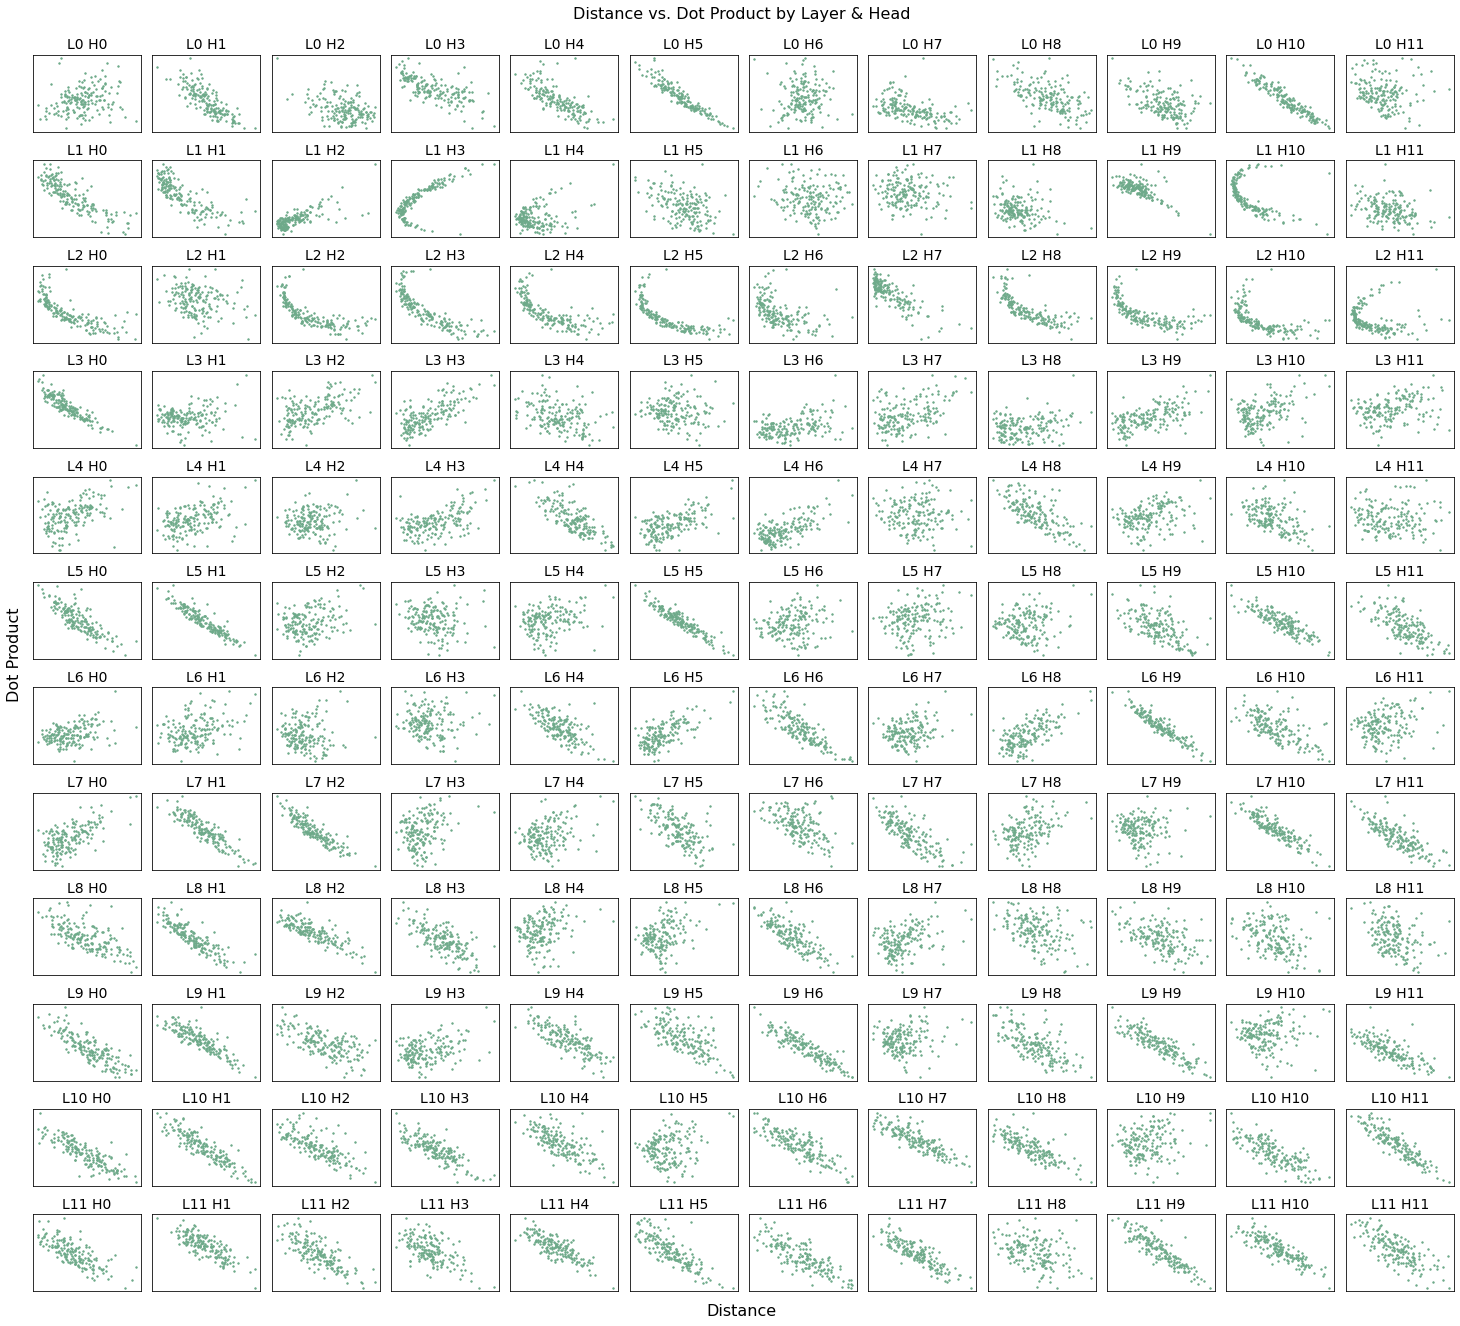

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# plt.scatter(overall_mean_d, overall_mean_a)
# plt.show()

fig, axs = plt.subplots(12, 12)

for layer in range(12):
    for head in range(12):
        ax = axs[layer, head]
        ax.scatter(distances[layer * 12 + head], sentence_mean_attn[layer * 12 + head], s=2, c='#6EAA8A')
        # ax.scatter(sentence_mean_dists[layer * 12 + head], sentence_mean_attn[layer * 12 + head], s=2, c='#6EAA8A')
        ax.set_title("L{} H{}".format(layer, head), fontsize=14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.suptitle('Distance vs. Dot Product by Layer & Head', fontsize=16, y=1)
fig.set_size_inches(20, 18)
fig.tight_layout(pad=0.8)
fig.text(0.5, -0.01, 'Distance', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Dot Product', va='center', rotation='vertical', fontsize=16)
plt.show()


### heatmaps

In [33]:
# library
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [14]:
# compute offset for each sentence in dataset
tok_sentences = attn_dict["tokenized_sentences"]
num_sent = len(tok_sentences)

offset = 0
sent_offset = []
while offset < num_sent:
    sent_offset.append(offset)
    cur_sent = tok_sentences[offset]
    sent_length = len(cur_sent.strip().split())
    if "   " in cur_sent:
        sent_length += 1
    offset += sent_length
    
print(len(sent_offset))
print(sent_offset[-1])

1000
28633


In [35]:
# find sentences w/ highest and lowest correlations
def find_high_and_low(layer, head, mean_cor, tok_sentences, sent_offset):
    means = mean_cor[layer * 12 + head]
    
    means_and_ind = [[means[i], i] for i in range(len(means))]
    means_and_ind = sorted(means_and_ind)
    
    k = 2
    lowest = means_and_ind[-2:]
    highest = means_and_ind[:2]
    
#     for l in lowest:
#         offset = sent_offset[l[1]]
#         sent = tok_sentences[offset]
#         print(sent)
        
#     for h in highest:
#         offset = sent_offset[h[1]]
#         sent = tok_sentences[offset]
#         print(sent)
    return lowest + highest
    
print(find_high_and_low(0, 1, mean_cor, tok_sentences, sent_offset))

[[-0.9289044289044289, 48], [-0.9284848484848485, 120], [-0.995145760010625, 3], [-0.9946923059765582, 69]]


In [36]:
print(find_high_and_low(2, 7, mean_cor, tok_sentences, sent_offset))

[[0.2806781042210296, 125], [0.3247525088543119, 94], [-0.8472727272727273, 120], [-0.843822843822844, 8]]


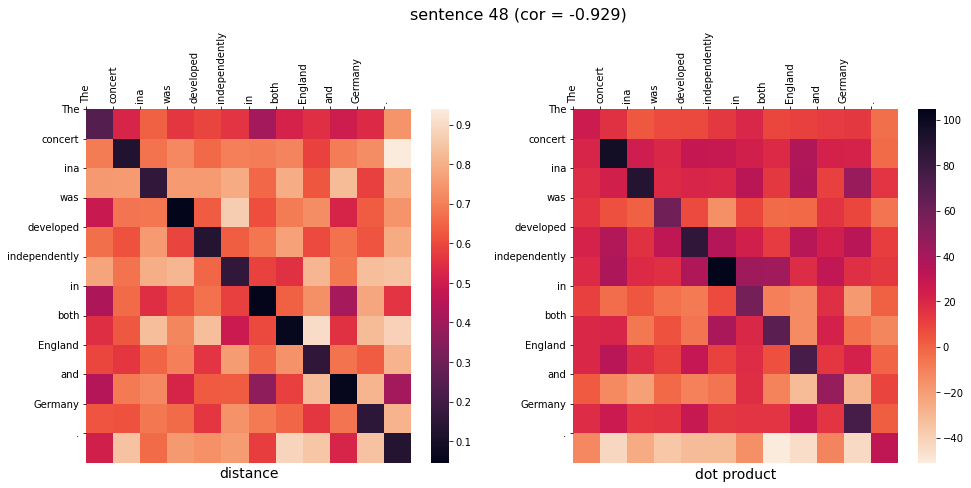

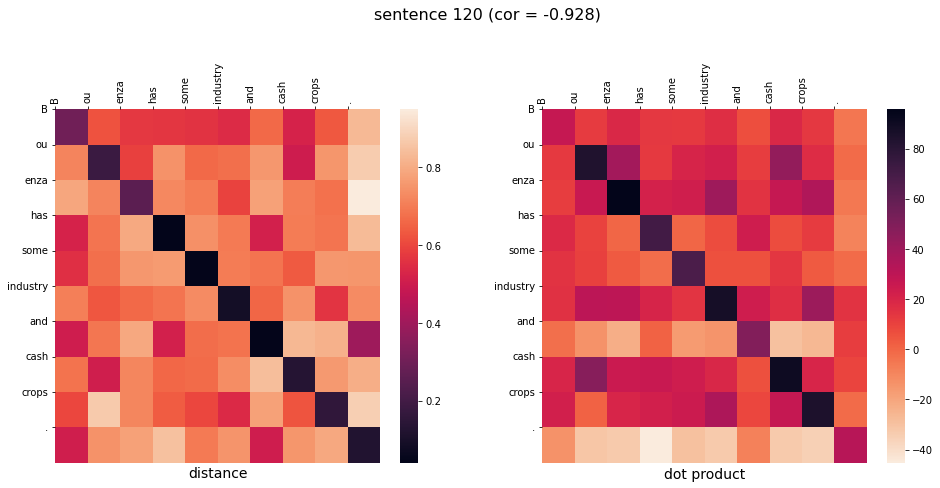

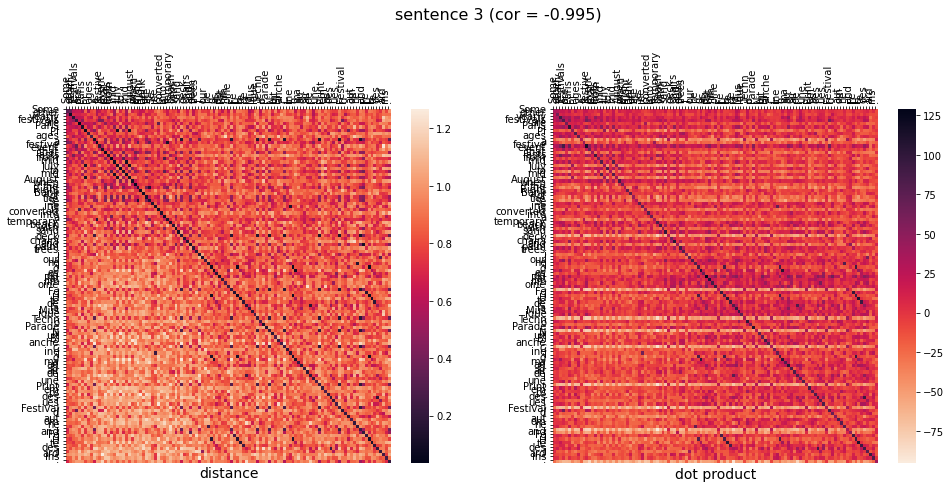

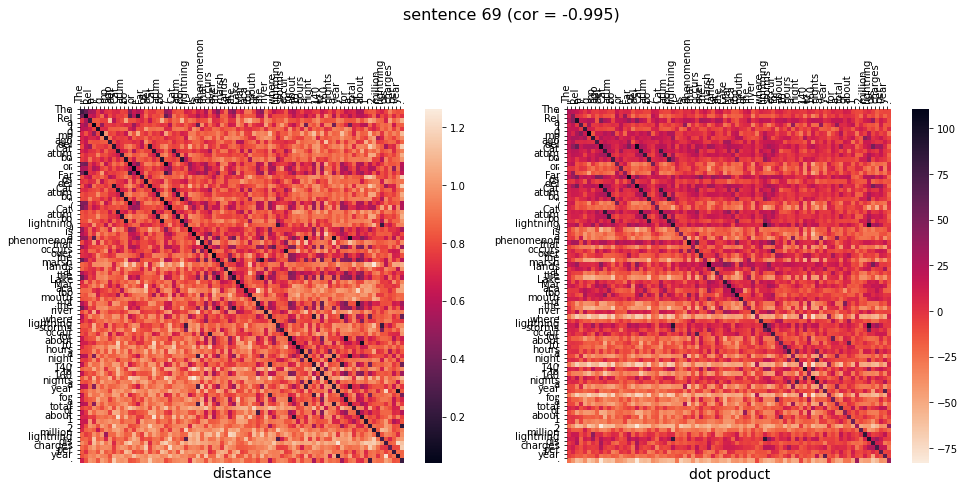

In [38]:
def make_heatmap(layer, head, distances, attention, mean_cor, sentences, sent_offset):
    d = distances[layer][head]
    a = attention[layer][head]
    
    res = find_high_and_low(layer, head, mean_cor, sentences, sent_offset)
    
    for r in res:
        i = r[1]
        c = r[0]
        offset = sent_offset[i]
        t = sentences[offset]
        
        sent_length = len(d[offset])
        dt = d[offset:offset+sent_length]
        at = a[offset:offset+sent_length]

        fig, axs = plt.subplots(ncols=2)
        fig.set_size_inches(16, 6.5)
        fig.suptitle('sentence {} (cor = {cor:.3f})'.format(i, cor=c), fontsize=16, y=1.1)

        sns.heatmap(dt, ax=axs[0])
        sns.heatmap(at, ax=axs[1], cmap = sns.cm.rocket_r)

        axs[0].set_xlabel('distance', fontsize=14)
        axs[0].set_xticks(range(sent_length), t.split(), rotation=90)
        axs[0].set_yticks(range(sent_length), t.split(), rotation=0)
        axs[0].xaxis.tick_top()

        axs[1].set_xlabel('dot product', fontsize=14)
        axs[1].set_xticks(range(sent_length), t.split(), rotation=90)
        axs[1].set_yticks(range(sent_length), t.split(), rotation=0)
        axs[1].xaxis.tick_top()

make_heatmap(0, 1, distances, attention, mean_cor, tok_sentences, sent_offset)

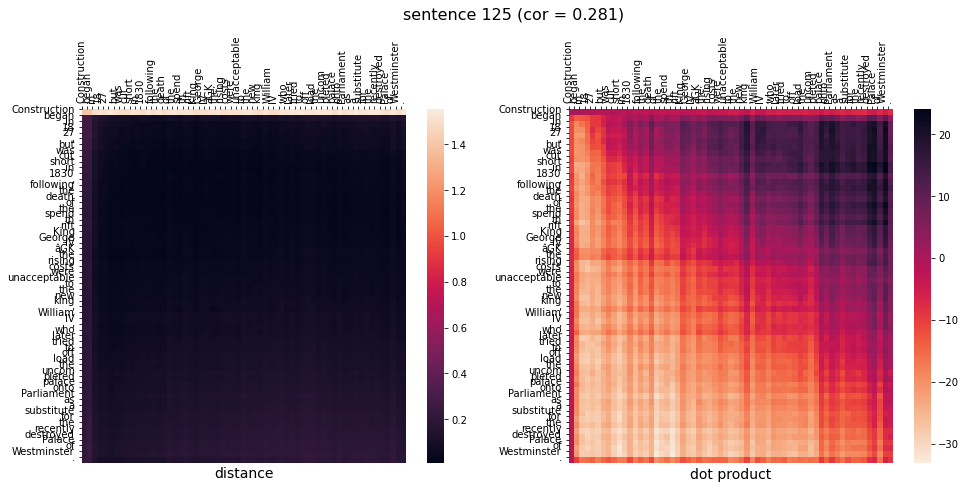

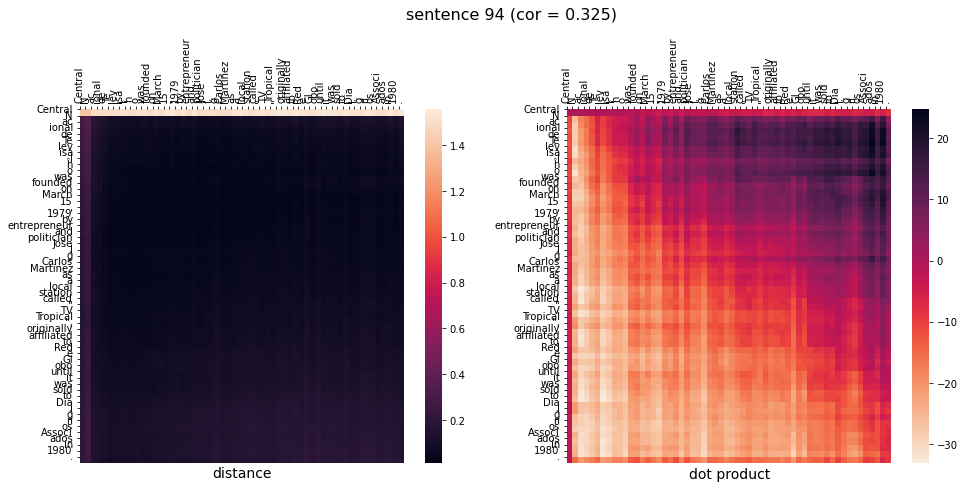

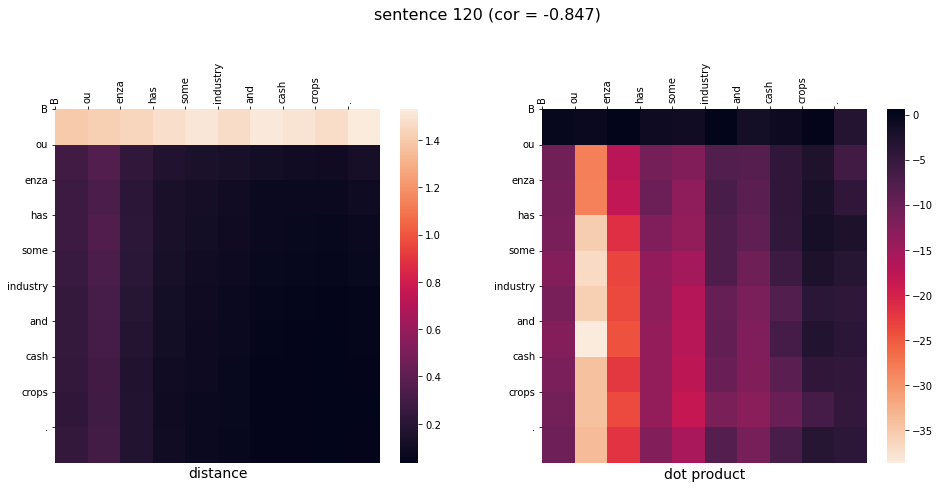

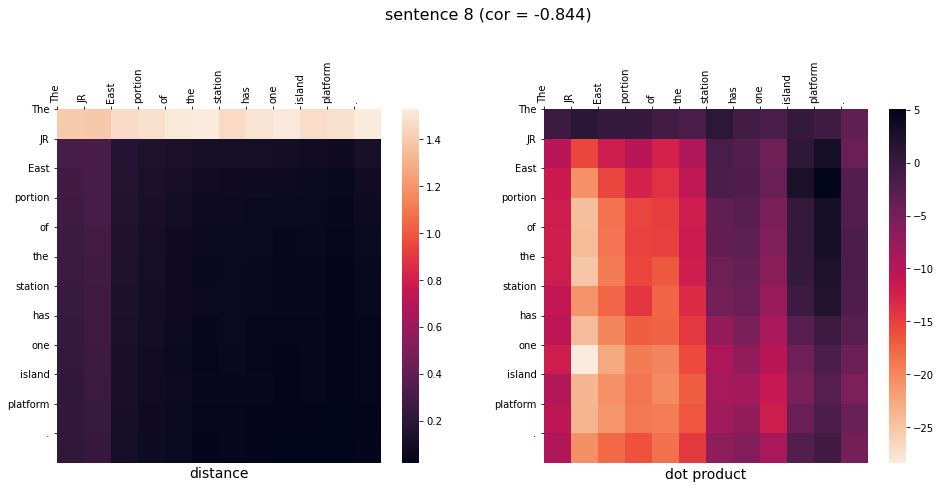

In [132]:
make_heatmap(2, 7, distances, attention, mean_cor, tok_sentences, sent_offset)


In [54]:
def print_norms(layer, head, distances, attention, mean_cor, sentences, sent_offset):
    # d = distances[layer][head]
    # a = attention[layer][head]
    q = query_norms[layer * 12 + head]
    k = key_norms[layer * 12 + head]
    
    res = find_high_and_low(layer, head, mean_cor, sentences, sent_offset)
    
    all_diffs = []
    for r in res:
        i = r[1]
        c = r[0]
        offset = sent_offset[i]
        t = sentences[offset]
        
        sent_length = len(d[offset])
        qt = q[offset:offset+sent_length]
        kt = k[offset:offset+sent_length]
        
        differences = []
        for a in range(len(qt)):
            q_diff = []
            for b in range(len(kt)):
                q_diff.append(qt[a] - kt[b])
            differences.append(q_diff)
        all_diffs.append(differences)
    return all_diffs

In [ ]:
differences = print_norms(2,7, distances, attention, mean_cor, sentences, sent_offset)
print(differences[0])

## norms check

In [119]:
query_norms = []
key_norms = []

# queries = attn_dict['queries']
# keys = attn_dict['keys']
for layer in range(12):
    for head in range(12):
        norms_q = []
        norms_k = []
        for i in range(len(queries[layer][head])):
            q = queries[layer][head][i]
            k = keys[layer][head][i]
            norms_q.append(np.linalg.norm(q))
            norms_k.append(np.linalg.norm(k))
        query_norms.append(norms_q)
        key_norms.append(norms_k)
    
    

### medians

In [120]:
import statistics

In [121]:
qmedians = []
kmedians = []
for i in range(len(query_norms)):
    # per head
    q_i = query_norms[i]
    k_i = key_norms[i]
    
    q_median = statistics.median(q_i)
    k_median = statistics.median(k_i)
    qmedians.append(q_median)
    kmedians.append(k_median)

In [122]:
print(qmedians)
print(kmedians)
overall_meanq = sum(qmedians) / len(qmedians)
overall_meank = sum(kmedians) / len(kmedians)
print("\nIn GPT, median query norm = {:2f}".format(overall_meanq))
print("\nIn GPT, median key norm = {:2f}".format(overall_meank))

[6.385145314891122, 10.353305238324312, 6.214738772355493, 11.167053726563328, 9.069412335550165, 10.63064514936137, 6.324500792982848, 9.066412876547533, 7.309727125940185, 5.7027536505656355, 5.904679896228158, 6.336903839596836, 8.328976320144493, 7.314916016175011, 9.587480969237077, 6.239972484812954, 6.802190535950985, 7.453516860670534, 6.977254157772555, 5.169702724518297, 4.634131875133996, 6.361190094316139, 8.616030385915128, 9.140377692655816, 8.569962091405971, 7.672658471852183, 13.469433895353749, 10.072105676797495, 12.225189634319117, 10.339511087706555, 7.929799167362889, 15.97596382198011, 10.325120485280081, 9.662899104579989, 5.890122756904541, 8.625045003082333, 12.585025307722754, 11.700346022216877, 12.282256539523432, 15.125336564394646, 9.238534355370572, 7.9644942224390345, 10.34424152087135, 12.286474359307794, 12.319808537424674, 11.368373793385079, 11.07635880148355, 10.395174246932191, 13.115370508426224, 11.626576117243804, 8.903459366378975, 10.54636609

### histograms

In [56]:
qnorms_formatted = [item for sublist in query_norms for item in sublist]
knorms_formatted = [item for sublist in key_norms for item in sublist]

In [16]:
import matplotlib.pyplot as plt
import numpy as np

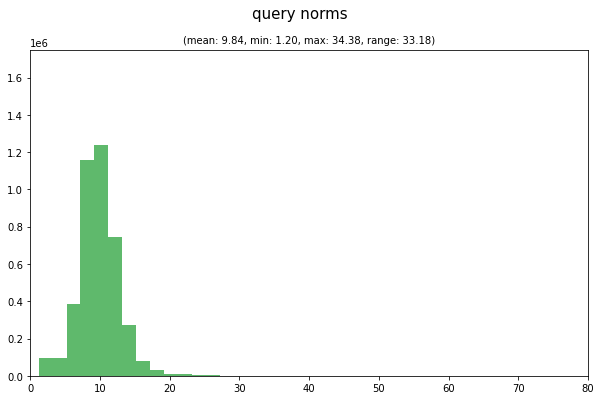

In [57]:
w = 2 # width
min_norm = min(qnorms_formatted)
max_norm = max(qnorms_formatted)
range_norm = max_norm - min_norm
mean_norm = sum(qnorms_formatted) / len(qnorms_formatted)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, 80), ylim=(0, 1.75e6))
plt.suptitle("query norms", fontsize=15)
plt.title("(mean: {:.2f}, min: {:.2f}, max: {:.2f}, range: {:.2f})".format(mean_norm, min_norm, max_norm, range_norm), fontsize=10)
plt.hist(qnorms_formatted, color="#5FB96C", bins=np.arange(min_norm, max_norm + w, w))
plt.show() 

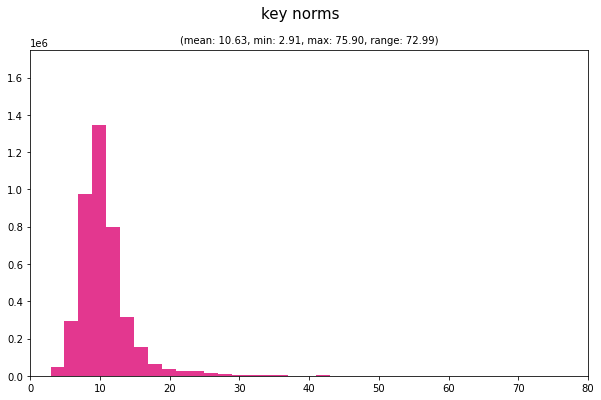

In [58]:
w = 2 # width
min_norm = min(knorms_formatted)
max_norm = max(knorms_formatted)
range_norm = max_norm - min_norm
mean_norm = sum(knorms_formatted) / len(knorms_formatted)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, 80), ylim=(0, 1.75e6))
plt.suptitle("key norms", fontsize=15)
plt.title("(mean: {:.2f}, min: {:.2f}, max: {:.2f}, range: {:.2f})".format(mean_norm, min_norm, max_norm, range_norm), fontsize=10)
plt.hist(knorms_formatted, color="#E3378F", bins=np.arange(min_norm, max_norm + w, w))
plt.show() 

### means overall

In [55]:
qmeans = []
kmeans = []
for i in range(len(query_norms)):
    # per head
    q_i = query_norms[i]
    k_i = key_norms[i]
    
    q_mean = sum(q_i) / len(q_i)
    k_mean = sum(k_i) / len(k_i)
    qmeans.append(q_mean)
    kmeans.append(k_mean)

In [49]:
print(qmeans)
print(kmeans)
overall_meanq = sum(qmeans) / len(qmeans)
overall_meank = sum(kmeans) / len(kmeans)
print("\nIn BERT, mean query norm = {:2f}".format(overall_meanq))
print("\nIn BERT, mean key norm = {:2f}".format(overall_meank))

[5.804464666628494, 6.629964240530195, 9.384715338052585, 8.974347423055436, 4.941735034814968, 7.143807658314274, 4.554904539738938, 6.121918424370859, 6.852282078330953, 6.880651084414074, 9.640509983151457, 8.374809862062325, 7.257040734019269, 11.584728290572135, 7.841810781183097, 7.39896463100121, 11.190269490612296, 8.423527704652564, 11.607999803258105, 7.168246472361359, 7.42673367306344, 6.512578799756211, 8.591792776156643, 8.454456880777292, 15.41616482158887, 11.173035686187445, 8.149111092003402, 6.796064863443437, 8.257540822442538, 7.532310520033966, 8.987196139356655, 7.891013635315311, 8.345983247184222, 15.367133598709943, 8.036071537705814, 7.708755005780715, 10.802215350650654, 7.603948816512074, 8.135829985395654, 8.587177614807022, 7.265160536355084, 11.532162577486186, 8.326398084820083, 7.155744089009506, 8.320009706796464, 10.534325445428479, 8.677080948638435, 9.055380905627276, 9.147259587143788, 7.427563797625298, 8.37952328593129, 12.058913063996128, 7.718

In [56]:
print(qmeans)
print(kmeans)
overall_meanq = sum(qmeans) / len(qmeans)
overall_meank = sum(kmeans) / len(kmeans)
print("\nIn GPT, mean query norm = {:2f}".format(overall_meanq))
print("\nIn GPT, mean key norm = {:2f}".format(overall_meank))

[6.303479115874019, 10.346450698233332, 6.258450259605766, 10.982835458677929, 9.042309019246957, 9.827459070058254, 6.339376831320323, 8.979522919901632, 7.261625052013326, 5.7490931976704, 5.918141108204352, 6.395144184723772, 8.245606808638684, 7.253399561901867, 9.743930778483563, 6.440446243467747, 6.802832807295896, 7.411325723728984, 6.832604376016875, 5.1833968578762954, 4.62577937018517, 6.40057821814093, 8.493308889285625, 8.867543147723818, 8.386072378740876, 7.531036795683727, 13.143148269302156, 9.79645599995528, 12.003805929149333, 10.05518726445374, 7.747559673906027, 15.438845292674088, 10.17598641896125, 9.477066337786656, 5.762760710883855, 8.596312528338247, 12.179571043567389, 11.379068097811945, 11.976453152432798, 14.782533855253096, 9.038822501786752, 7.852402357635353, 10.113796582360663, 11.943519131917437, 11.979983037220075, 11.127087741098606, 10.839358771136997, 10.169451865178221, 12.797602776982519, 11.347804992599462, 8.752968933385858, 10.38259415817595

### first token - others

In [43]:
# difference between first token and rest of words in sentence
query_diffs = []
key_diffs = []

for i in range(len(query_norms)):
    # per head
    q_i = query_norms[i]
    k_i = key_norms[i]
    
    qhead_diff = []
    khead_diff = []
    
    for s in range(len(sent_offset) - 1):
        offset = sent_offset[s]
        end_offset = sent_offset[s+1]
        q_sent = q_i[offset:end_offset]
        k_sent = k_i[offset:end_offset]
        
        for j in range(1, len(q_sent)):
            qdiff = q_sent[0] - q_sent[j]
            qhead_diff.append(qdiff)
            kdiff = k_sent[0] - k_sent[j]
            khead_diff.append(kdiff)
    query_diffs.append(qhead_diff)
    key_diffs.append(khead_diff)

In [44]:
# mean differences
qmeans = []
kmeans = []
for d in range(len(query_diffs)):
    qhead = query_diffs[d]
    khead = key_diffs[d]
    qmean = sum(qhead) / len(qhead)
    kmean = sum(khead) / len(khead)
    qmeans.append(qmean)
    kmeans.append(kmean)

In [28]:
print(qmeans)
print(kmeans)
overall_meanq = sum(qmeans) / len(qmeans)
overall_meank = sum(kmeans) / len(kmeans)
print("\nOn average in GPT, query 1st token norm - other token norm = {:2f}".format(overall_meanq))
print("\nOn average in GPT, key 1st token norm - other token norm = {:2f}".format(overall_meank))

[-2.09572970235419, -3.5204237895500072, -1.788684630215809, -4.5616979264901385, -3.967209956085662, -1.0569068397935637, -1.8887003117752592, -4.168567537905641, -2.924250476938273, -1.08189745963268, -1.7796403613714673, -1.573759630625137, -5.190514989883438, -3.999368018630939, -4.826589939287905, -2.2957271993108463, -2.39677795453455, -3.109239279307426, -3.231506953105417, -2.2416490866821137, 0.4084381398431404, 0.6914892159800924, -2.52004567616411, -4.4471123625535585, -6.1951739804759445, -5.473272635923191, -9.579058210290963, -7.516151513036044, -8.79364732073858, -7.500996491249839, -6.065775985415019, -11.66971614013525, -7.8073555360329845, -6.814255267504891, -4.359502038899609, -6.342541269321636, -9.96772252735249, -9.390864700134882, -10.149541457315868, -12.632545423414538, -7.056637346568893, -6.270669688831983, -8.514928606828667, -10.092750642236835, -10.010795798456797, -9.521495403445641, -7.874790773155066, -8.351399942506463, -11.006525376550599, -9.6832431

In [45]:
print(qmeans)
print(kmeans)
overall_meanq = sum(qmeans) / len(qmeans)
overall_meank = sum(kmeans) / len(kmeans)
print("\nOn average in BERT, query 1st token norm - other token norm = {:2f}".format(overall_meanq))
print("\nOn average in BERT, key 1st token norm - other token norm = {:2f}".format(overall_meank))

[-0.00327892403833321, 0.009272263866572946, -0.0013047922903278327, -0.014157800129239638, 0.014597930282028911, 0.007185981791871587, -0.012853735159658024, 0.010340158766267154, 0.012126380595369282, 0.014927802636581888, -0.004467354448516972, 0.017764734465803095, 0.03167553088171493, 0.006222653716580602, 0.01715868962800282, -0.019904289631234754, -8.426162199190756e-05, -0.014576254237677248, 0.002513404091436579, 0.006662924548430089, 0.03066643029011919, 0.027187382122708277, -0.000251908974426694, -0.00405804140369889, 0.003467616650950694, 0.02318325656659838, 0.009842395296749719, 0.02778124333455089, 0.017354079058800546, -0.01359411968380505, 0.0016162114126017165, -0.01240208989958549, -0.017122970889025334, 0.009329885964057962, 0.040985691421821464, 0.017233302486781527, -0.008794813688873426, 0.007483062750267437, 0.007278974901950733, 0.001937495245050116, -0.025068024257271015, -0.018795720372892014, -0.02358475967219869, -0.0256514929536349, 0.03373848903072534, -

### differences

In [46]:
# get differences in norms
differences = []
for i in range(len(query_norms)):
    q_i = query_norms[i]
    k_i = key_norms[i]
    
    head_diff = []
    for j in range(len(q_i)):
        diff = q_i[j] - k_i[j]
        head_diff.append(diff)
    differences.append(head_diff)
    

In [108]:
# # mean differences
# means = []
# for d in differences:
#     mean = sum(d) / len(d)
#     means.append(mean)
    

In [102]:
print(means)
overall_mean = sum(means) / len(means)
print("\nOn average in GPT, query norm - key norm = {:2f}".format(overall_mean))

[-4.205138540239247, -0.9671118763640468, -3.820439301007674, -9.752071793229245, -4.544361230333584, -1.4837273464847107, -4.534012094190735, -5.760059003069102, -3.028551881234353, -2.071146369676036, -2.41857243730256, 0.3207644351913907, -5.584718851529235, -4.974946138330646, 5.4465231250440205, 1.0429136652070552, 0.40472271063104287, -1.8074351110640616, -4.442906508561463, -5.567855051119451, -5.952693534411101, -2.8141240616734273, 4.0811371287076685, -0.918074457915857, -3.637952377537023, -2.6419766624240273, -11.092276345430145, -8.964571018879647, -4.982724906778767, -8.799914069988377, -3.368222644105994, 6.222980124808062, -8.606165687691524, -10.72333908042801, -6.33200607340194, 1.6760117138108137, 1.4204042436788205, -12.96884890140561, -27.99275002425031, -19.485925527501596, -0.761865511018941, -7.214082092642906, -24.280210010179285, -27.780139132603786, -22.25835142750529, -14.887857210563448, -4.131322100675417, -19.524922324273504, -14.384183105240794, -15.58459

In [109]:
# mean differences
means2 = []
for d in differences:
    mean = sum(d) / len(d)
    means2.append(mean)

In [110]:
print(means2)
overall_mean2 = sum(means2) / len(means2)
print("\nOn average in BERT, query norm - key norm = {:2f}".format(overall_mean2))

[-1.5183002420491525, -1.2370236385087976, -0.06897264464544896, -0.7068800402563176, -1.792909135901775, -0.311961555963498, -2.2703529371196063, -1.5310760990086207, -1.6478284888873185, 0.08669041616211236, -0.5738418886677059, -0.19332627017312362, -0.6244098233434875, 0.8507336602207918, 0.4925163244044577, 0.47002308373454094, -0.00019720752941526434, 0.35821434279074976, 1.7053985071654252, 0.01782580903344787, 0.4141932144798883, -0.4408498480478746, -0.043771182211223995, 0.6480493243650342, 1.373572338575082, 0.8995868962021422, 0.7003956442653924, 0.3129441553423462, 0.5085870769277475, 0.21269088627929555, 0.10593291791633414, 0.2816015943973198, 0.3241300068674243, 1.2146214735778644, 0.7430923483473081, -0.3359851804932604, 1.2344441012615857, 0.5981704149188787, 0.4051290200162978, -0.48358318537600825, -0.21925619466871973, 0.8413875783845272, 0.4218030453931291, -0.2863879665292368, 0.6684564227937821, -0.13087416895627962, -0.10652680966907993, -0.26080573721128186, 1

## Playing with TSNE / UMAP

Generating plots from query + key vectors

### installs

In [21]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 33.7 MB/s eta 0:00:0000:0100:01


In [14]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 3.0 MB/s eta 0:00:00a 0:00:01


In [38]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 23.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 19.9 MB/s eta 0:00:0000:0100:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82814 sha256=169373e8bb5cb82e3bcac1d00b104fe854393ce62f49910cdc9da76058d80e00
  Stored in directory: /n/home10/cyeh/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54269 sha256=dc67c746d8ca0eb892487da0989f8bcfea79b492207d2462f55a243a553196e6
  Stored in directory: /n/home10/cyeh/.cache/pip/wheels/5b/f5/6e/aac11d69fe2115d9ac871d6c148b361f0d3f8a35ed7354fa03
Successful

### start code

In [8]:
# import
from sklearn.manifold import TSNE
from umap import UMAP
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# ensure plots show up in jupyter
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"

In [3]:
import pickle
# load attn_dict back
attn_dict = pickle.load( open( "attn_dict.p", "rb" ) )

In [10]:
# produce corresponding key matrix from query matrix (e.g., for attention)
def k_matrix(q_matrix):
    # assumes for specific layer + head (e.g., queries[0][0])
    num_tokens = len(q_matrix)
    k_matrix = []
    i = 0
    while i < num_tokens:
        q = q_matrix[i]
        sent_length = len(q)
        for k_i in range(sent_length):
            k = []
            for q_i in range(sent_length):
                k.append(q_matrix[q_i + i][k_i])
            k_matrix.append(k)
        i += sent_length
    
    return k_matrix
    
# res = k_matrix(attn_dict["attn"][0][0][:13])
# print(attn_dict["attn"][0][0][:13])
# print(res)
# print(len(res))
# print(len(res[0]))

In [49]:
#layer = 0
#head = 0

def fix_sentences(sentences, positions, types):
    # format sentences to be displayed in html plot
    new_sentences = []
    for sent, pos, t in zip(sentences, positions, types):
        s_arr = sent.split()
        s = ""
        for i in range(len(s_arr)):
            if i % 10 == 0 and i not in [0, len(s_arr) - 1]:
                s += "<br>" # add new line every 10 tokens
                
            if i == pos: # italicize  + color current token
                color = "#B6E1B9"
                if t == "key":
                    color = "#F6BA98"
                s += "<b style='color:" + color + "'>" + s_arr[i] + "</b>"
            else:
                s += s_arr[i]
                
            if s != len(s_arr) - 1:
                s += " " # add space back between each token
        new_sentences.append(s)
    
    return new_sentences

def make_df(layer, head):
# convert data into pandas dataframe
    df = pd.DataFrame()
    df['token'] = attn_dict['left_text'] + attn_dict['right_text'] # store tokens
    df['token'] = df['token'].str.lower() # convert to lowercase
    num_tokens = len(attn_dict['left_text'])
    
    df['type'] = ['query'] * num_tokens + ['key'] * num_tokens # store token type
    df['pos_int'] = attn_dict['positions'] * 2 # positions
    df['position'] = attn_dict['normalized_positions'] * 2
    
    # sentence itself
    # df['sentence'] = fix_sentences(attn_dict['tokenized_sentences'], attn_dict['positions'], df['type'][:num_tokens]) + fix_sentences(attn_dict['tokenized_sentences'], attn_dict['positions'], df['type'][num_tokens:])
    df['sentence'] = [s.lower() for s in attn_dict['tokenized_sentences']] * 2
    
    # save attn info
    attn = attn_dict['attn'][layer][head]
    df['attn'] = attn + k_matrix(attn)
    #df['max_ind'] = [a.index(max(a)) for a in df['attn']]
    dp = attn_dict['dot_prod'][layer][head]
    df['dot_prod'] = dp + k_matrix(dp)
    
    # extract q/k vectors
    queries = attn_dict['queries']
    keys = attn_dict['keys']
    # queries = new_queries
    # keys = new_keys
    vec_size = len(queries[layer][head][0])

    # norms
    norms_q = []
    norms_k = []
    for i in range(len(queries[layer][head])):
        q = queries[layer][head][i]
        k = keys[layer][head][i]
        norms_q.append(np.linalg.norm(q))
        norms_k.append(np.linalg.norm(k))
    df["norm"] = norms_q + norms_k
    
    # df = pd.concat([df.iloc[:5021], df.iloc[30070:30070+5021]]) # only get first X keys + queries

    for i in range(vec_size): # store q/k vector values
        qs = [queries[layer][head][j][i] for j in range(num_tokens)]
        ks = [keys[layer][head][j][i] for j in range(num_tokens)]
        df["f" + str(i)] = qs + ks # add to dataframe
        
    # comment out line below if want all 60k data points
    df = pd.concat([df.iloc[:5007], df.iloc[28679:28679+5007]]) # gpt
    # df = pd.concat([df.iloc[:5021], df.iloc[30070:30070+5021]]) # bert
    # df = pd.concat([df.iloc[:5024], df.iloc[30085:30085+5024]]) # only get first X keys + queries
    # print(len(df))
    # df_lab = df.iloc[:, :8].copy() # get label cols only
    # df.to_csv('layer{}_head{}.csv'.format(layer, head), index=False)
    # df_lab.to_csv('layer' + str(layer) + '/labels' + str(head) + '.tsv', sep="\t", index=False) # save labels to file
    
    return df

# testing
df = make_df(1, 2)
df.tail(10)

,token,type,pos_int,position,sentence,attn,dot_prod,norm,f0,f1,...,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63
33676,degree,key,6,0.400000,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1243270859122...","[-13.046032464386531, -18.92044913470422, -15....",4.251553,-0.165490,-0.455163,...,0.028001,-0.104282,0.945354,1.356283,-0.630933,0.066298,-0.049647,-0.961263,0.051021,0.192271
33677,from,key,7,0.466667,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21140174...","[-9.542935143126776, -11.027076613057744, -9.2...",4.351697,-0.070377,-0.186032,...,-0.170136,-0.173247,0.799077,1.296030,-0.558702,0.111981,-0.055555,-0.957584,0.231267,0.217181
33678,the,key,8,0.533333,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.184...","[-8.333902244105557, -10.565040761095037, -8.5...",4.386984,-0.070236,-0.077174,...,-0.204657,-0.889120,1.125555,1.468779,-0.615570,0.444403,-0.198410,-0.688448,0.377872,0.207750
33679,university,key,9,0.600000,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-11.55961318626591, -17.469658300678933, -14....",4.025716,0.277272,-0.527442,...,-0.376452,0.061742,0.701747,1.613002,-0.626181,0.169012,-0.079601,-0.951412,-0.002236,0.427343
33680,of,key,10,0.666667,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-7.360348619543907, -8.452249927709813, -7.01...",4.330401,-0.123005,-0.131495,...,0.009633,-0.267608,0.925500,1.464080,-0.753767,0.230120,-0.294182,-0.773124,0.115910,0.165729
33681,western,key,11,0.733333,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-11.464520825201133, -17.9277108617094, -15.2...",4.001034,0.165821,-0.384317,...,-0.382434,-0.054419,0.783440,1.707273,-0.544521,-0.166136,-0.162974,-0.666544,-0.319569,0.215440
33682,australia,key,12,0.800000,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.3018655622655, -11.14412708360897, -9.2368...",3.814458,-0.466861,-0.324063,...,-0.251508,-0.372671,0.765145,1.444870,-0.139269,-0.091538,-0.055186,-0.848108,0.338557,0.503233
33683,in,key,13,0.866667,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.073180669600748, -6.427793515842042, -5.40...",4.122116,-0.114905,-0.339134,...,-0.243867,-0.301714,0.702755,1.554849,-0.609225,0.311219,-0.229851,-0.780414,0.296170,0.371514
33684,1964,key,14,0.933333,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.256445914490332, -14.140688783935488, -12....",3.593744,-0.298268,-0.187092,...,-0.426633,-0.132420,0.587476,1.576056,-0.139140,0.010959,-0.392681,-0.722634,0.324757,0.282162
33685,.,key,15,1.000000,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.661043644538163, -5.052468780170742, -4.15...",3.912532,-0.107773,-0.182402,...,0.032009,-0.137743,0.380034,1.299862,-0.611678,0.111740,-0.046442,-1.232940,0.076320,-0.036805


### translating key vectors
Translate keys to have same centroid as queries for easier(?) comparison

In [34]:
def find_q_means(df):
    # find mean of each feature in query embeddings
    df_queries = df.loc[df['type'] == 'query']
    df_queries = df_queries.iloc[:, 8:].copy()
    # df_queries.head()
    query_means = df_queries.mean(axis=0)
    return query_means

# query_means = find_q_means(df)
# query_means

In [13]:
def find_q_means_selective(df):
    # find mean of each feature in query embeddings if norm is around mean
    # mean_norm = df["norm"].median()
    # print(mean_norm)
    mean_norm = 9.84 # GPT query norm
    lower_bound = mean_norm - 1
    upper_bound = mean_norm + 1
    df_queries = df.loc[(df['type'] == 'query') & (df['norm'] > lower_bound) & (df['norm'] < upper_bound)]
    df_queries = df_queries.iloc[:, 8:].copy()
    # df_queries.head()
    query_means = df_queries.mean(axis=0)
    return query_means
    
# find_q_means_selective(df)

In [35]:
def find_k_means(df):
    # find mean of each feature in key embeddings
    df_keys = df.loc[df['type'] == 'key']
    df_keys = df_keys.iloc[:, 8:].copy()
    # df_keys.head()
    key_means = df_keys.mean(axis=0)
    # key_means
    return df_keys, key_means

# df_keys, key_means = find_k_means(df)
# key_means

In [36]:
def translate_keys(df, df_keys, query_means, key_means):
# translate key vectors accordingly
    # new_keys = pd.DataFrame()
    for i in range(64):
        col = "f" + str(i)
        new_key = df_keys[col] - key_means[col] + query_means[col]
        df.loc[df['type'] == 'key', col] = new_key

    # print(new_keys.head())
    new_means = df[df.type == 'key'].mean(axis=0)
    # print(new_means)
    # df.tail()
    return df

# df = translate_keys(df, df_keys, query_means, key_means)

In [44]:
def translate_queries_and_keys(df):
    df_queries = df.loc[df['type'] == 'query']
    df_queries = df_queries.iloc[:, 8:].copy()
    df_keys = df.loc[df['type'] == 'key']
    df_keys = df_keys.iloc[:, 8:].copy()
    for i in range(64):
        col = "f" + str(i)
        new_key = df_keys[col]*10
        new_query = df_queries[col]/10
        df.loc[df['type'] == 'key', col] = new_key
        df.loc[df['type'] == 'query', col] = new_query
    return df

df = translate_queries_and_keys(df)

In [50]:
# whole translation loop
def translate_loop(df): 
    query_means = find_q_means(df)
    # query_means = find_q_means_selective(df)
    df_keys, key_means = find_k_means(df)
    df = translate_keys(df, df_keys, query_means, key_means)
    return df

df = translate_loop(df)
df.tail()

<ipython-input-36-e5a17867bf1e>:10: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,token,type,pos_int,position,sentence,attn,dot_prod,norm,f0,f1,...,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63
33681,western,key,11,0.733333,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-11.464520825201133, -17.9277108617094, -15.2...",4.001034,0.406407,-0.824863,...,-0.304570,-0.685819,-0.349346,-2.975479,3.178447,0.295821,-0.071158,1.000928,-0.156295,-0.136290
33682,australia,key,12,0.800000,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.3018655622655, -11.14412708360897, -9.2368...",3.814458,-0.226276,-0.764609,...,-0.173644,-1.004072,-0.367642,-3.237883,3.583699,0.370419,0.036630,0.819364,0.501831,0.151504
33683,in,key,13,0.866667,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.073180669600748, -6.427793515842042, -5.40...",4.122116,0.125681,-0.779680,...,-0.166003,-0.933115,-0.430032,-3.127903,3.113744,0.773176,-0.138035,0.887057,0.459444,0.019785
33684,1964,key,14,0.933333,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.256445914490332, -14.140688783935488, -12....",3.593744,-0.057683,-0.627638,...,-0.348769,-0.763821,-0.545311,-3.106696,3.583829,0.472915,-0.300865,0.944837,0.488032,-0.069568
33685,.,key,15,1.000000,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.661043644538163, -5.052468780170742, -4.15...",3.912532,0.132812,-0.622948,...,0.109873,-0.769143,-0.752753,-3.382890,3.111290,0.573697,0.045374,0.434532,0.239595,-0.388535


### subtracting position

In [66]:
def subtract_pos(df, layer, head, all_embeddings):
    resids = get_residual(layer, head, all_embeddings)
    for p in range(len(pos_embeddings)):
        for i in range(64):
            # col = "f" + str(i)
            df.iloc[p, 8 + i] -= resids[p][i] - pos_embeddings[p][i]
    
    return df
   
# df = subtract_pos(df, 3, 3, all_embeddings)
# df.tail()

### plot generation

#### pca

In [25]:
# imports
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import seaborn as sns

In [17]:
# run PCA
def run_pca(df, dim, layer, head):
     # prepare data for feature plot
    df_sub = df.iloc[:, 8:].copy()
    df_subset = df_sub.values # only get feature cols
    
    # run PCA
    time_start = time.time()
    
    if dim == 3:
        pca = PCA(n_components=3) # 3D
    else:
        pca = PCA(n_components=2) # 2D
    pca_results = pca.fit_transform(df_subset)
    np.save("pca" + str(dim) + "d/layer" + str(layer) + "_head" + str(head) + ".npy", pca_results) # save results too
    print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
#     type_list = list(df['type'])
#     # Create dataframe
#     if dim == 2: # 2D
#         pca_df = pd.DataFrame(
#             data=pca_results, 
#             columns=['PC1', 'PC2'])
#     else:
#         pca_df = pd.DataFrame( # 3D
#             data=pca_results,  
#             columns=['PC1', 'PC2', 'PC3'])

#     pca_df['type'] = type_list
#     return pca_df

In [77]:
def plot_pca(df, layer, head):
    sns.set()
    colors = ['#5FB96C', '#E3378F']
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))

    sns.lmplot(
        x='PC1', 
        y='PC2', 
        data=df, 
        hue='type', 
        fit_reg=False, 
        legend=True
        )

    plt.title('Layer {} Head {}'.format(layer, head))
    plt.savefig('pca/layer{}_head{}.png'.format(layer, head))
    # plt.show()

In [20]:
def pca_loop(layer, head):
    df2 = make_df(layer, head)
    df2 = translate_loop(df2)
    # run_pca(df2, 2, layer, head) # 2d
    run_pca(df2, 3, layer, head) # 3d
    # plot_pca(pca_df, layer, head)
    
    

In [ ]:
for layer in range(12):
    for head in range(12):
        pca_loop(layer, head)
        print("Layer {}, head {} done!".format(layer, head))
              

In [ ]:
## make grid
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


def img_reshape(img):
    img = Image.open('pca/'+img).convert('RGB')
    img = img.resize((400,300))
    img = np.asarray(img)
    return img

images = os.listdir('pca/')
img_arr = []

for layer in range(12):
    for head in range(12):
        img_arr.append(img_reshape("layer{}_head{}.png".format(layer, head)))
    
rows = 12
cols = 12
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24,20))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(images):
            axes[i, j].axis('off')
            axes[i, j].imshow(img_arr[img_count])
            img_count+=1
            
plt.tight_layout()
fig.suptitle('PCA results by attention head', fontsize=16, y=1.01)
fig.text(0.5, -0.01, 'Head', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Layer', va='center', rotation='vertical', fontsize=16)
plt.show()

#### tsne + umap

##### projection of projections

###### dists

In [24]:
new_features = []
layers = []
heads = []
for layer in range(12):
    for head in range(12):
        dists = all_dists[layer][head]
        head_d = []
        for d in dists:
            head_d.extend(d)
        dists = np.asarray(head_d)
        new_features.append(dists)
        layers.append(layer)
        heads.append(head)
        
df = pd.DataFrame()
df["layers"] = layers
df["heads"] = heads

###### coords from file

In [8]:
import os

In [82]:
queries = attn_dict["queries"]
keys = attn_dict["keys"]

In [83]:
new_features = []
layers = []
heads = []
for layer in range(12):
    for head in range(12):
        q = queries[layer][head][:5007]
        k = queries[layer][head][:5007]
        q = np.asarray(q).flatten()
        k = np.asarray(k).flatten()
        combined = np.concatenate((q, k), axis=None)
        new_features.append(combined)
        layers.append(layer)
        heads.append(head)
        
df = pd.DataFrame()
df["layers"] = layers
df["heads"] = heads

In [89]:
# gpt
patterns = ["other", "self", "other", "self", "self", "self", "other", "other", "other", "other", "other", "other",
            "other", "other", "other", "other", "other", "other", "other", "other", "other", "other", "other", "self",
            "other", "other", "previous", "other", "other", "other", "other", "other", "other", "other", "other", "other",
            "self", "other", "other", "previous", "self", "other", "previous", "previous", "other", "other", "other", "other",
            "other", "other", "other", "other", "self", "other", "other", "self", "self", "other", "other", "previous",
            "ind-next", "ind-next", "other", "other", "other", "ind-next", "previous", "other", "ind-next", "other", "other", "self",
            "other", "other", "other", "other", "other", "other", "self", "other", "previous", "ind-next", "ind-next", "other",
            "previous", "other", "ind-next", "other", "ind-prev", "other", "other", "other", "other", "other", "ind-next", "ind-next",
            "other", "ind-next", "other", "other", "other", "other", "ind-next", "other", "other", "other", "other", "other",
            "other", "ind-next", "other", "other", "other", "self", "ind-next", "other", "other", "ind-next", "other", "other",
            "ind-next", "ind-next", "other", "other", "other", "other", "ind-next", "ind-next", "other", "other", "other", "ind-next",
            "other", "other", "other", "other", "other", "other", "other", "other", "self", "ind-next", "ind-next", "other"]
df['patterns'] = patterns

In [25]:
# bert
patterns = ["other", "other", "previous", "previous", "other", "other", "other", "other", "other", "other", "next", "other",
            "other", "next", "other", "other", "previous", "other", "other", "other", "other", "other", "other", "self",
            "next", "other", "other", "other", "other", "other", "self", "other", "other", "next", "other", "other",
            "self", "other", "other", "next", "other", "previous", "other", "other", "other", "next", "other", "previous",
            "other", "other", "other", "self", "other", "other", "other", "other", "other", "other", "other", "next",
            "other", "other", "other", "other", "other", "self", "other", "other", "other", "next", "previous", "other",
            "self", "other", "other", "other", "other", "other", "next", "other", "other", "other", "other", "previous",
            "ind-next", "other", "next", "other", "previous", "other", "other", "other", "other", "other", "other", "other",
            "other", "other", "ind-next", "self", "other", "other", "other", "other", "other", "other", "other", "other",
            "self", "other", "other", "other", "other", "other", "self", "self", "self", "ind-prev", "other", "other",
            "other", "self", "other", "other", "other", "self", "self", "other", "other", "self", "self", "other",
            "other", "other", "other", "other", "other", "self", "other", "self", "self", "other", "self", "self"]
df['patterns'] = patterns

In [26]:
def run_tsne(coords, model, dim):
    time_start = time.time()
    if dim == 3: # 3D
        tsne = TSNE(n_components=3, verbose=0, perplexity=15, n_iter=300, metric="euclidean") # 3D
    else: # 2D
        tsne = TSNE(n_components=2, verbose=0, perplexity=15, n_iter=300, metric="euclidean") # 2D
    tsne_results = tsne.fit_transform(coords)
    # np.save("tsne/{}_{}d.npy".format(model, dim), tsne_results) # save tsne results too
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results

# tsne_results = run_tsne(all_coords, "gpt", 2)

In [27]:
def run_umap(coords, model, dim):
    time_start = time.time()
    if dim == 3: # 3D
        umap = UMAP(n_components=3, init='random', random_state=0, metric="euclidean")
    else: # 2D
        umap = UMAP(n_components=2, init='random', random_state=0, metric="euclidean")
    umap_results = umap.fit_transform(coords)
    # np.save("umap/layer" + str(layer) + "_head" + str(head) + ".npy", umap_results) # save umap results too
    print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return umap_results

In [43]:
def run_pca(df, model, dim):
    time_start = time.time()
    if dim == 3:
        pca = PCA(n_components=3) # 3D
    else:
        pca = PCA(n_components=2) # 2D
    pca_results = pca.fit_transform(df)
    # np.save("pca" + str(dim) + "d/layer" + str(layer) + "_head" + str(head) + ".npy", pca_results) # save results too
    print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
    return pca_results

In [28]:
def make_fig(results, df, model, dim, viz, colorby):
    # 2D version
    if colorby == "layer":
        df_color = df.layers
    elif colorby == "head":
        df_color = df.heads
    else: # patterns
        df_color = df.patterns
        
    if dim == 2:
        fig = px.scatter(
            results, x=0, y=1,
            title='{} of {} attention heads (2D)'.format(viz, model),
            color=df_color,
            labels={'color': colorby},
            color_discrete_sequence=px.colors.qualitative.Pastel,
            height=800,
            width=1200,
            opacity=1
        )
    else: # 3d
        fig = px.scatter_3d(
            results, x=0, y=1, z=2,
            title='{} of {} attention heads (3D)'.format(viz, model),
            color=df_color,
            labels={'color': colorby},
            height=800,
            opacity=1
        )
    fig.update_traces( # queries
        customdata=df[['layers', 'heads']],
        hovertemplate="layer: %{customdata[0]}, head: %{customdata[1]}",
    )
    
    fig.show()
    
# make_fig(tsne_results, df, "GPT", 2, "TSNE")

In [29]:
# loop
def proj_heads2(all_coords, df, vis, model, dim, colorby):
    if vis == "TSNE":
        results = run_tsne(all_coords, model, dim)
    elif vis == "UMAP":
        results = run_umap(all_coords, model, dim)
    else: # PCA
        results = run_pca(all_coords, model, dim)
    make_fig(results, df, model, dim, vis, colorby)

##### gpt (concatenating vectors)

In [ ]:
proj_heads2(new_features, df, "TSNE", "GPT", 2, "pattern")

In [47]:
proj_heads2(new_features, df, "TSNE", "GPT", 3, "layer")

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 6.603795051574707 seconds


In [91]:
proj_heads2(new_features, df, "UMAP", "GPT", 2, "pattern")

UMAP done! Time elapsed: 2.192448377609253 seconds


In [78]:
proj_heads2(new_features, df, "UMAP", "GPT", 3, "pattern")

UMAP done! Time elapsed: 8.518925189971924 seconds


In [ ]:
proj_heads2(new_features, df, "PCA", "GPT", 2, "layer")

In [89]:
proj_heads2(new_features, df, "PCA", "GPT", 3, "layer")

PCA done! Time elapsed: 4.5829925537109375 seconds


##### bert (concatenating vectors)

In [37]:
proj_heads2(new_features, df, "TSNE", "BERT", 2, "pattern")

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 0.9644548892974854 seconds


In [31]:
proj_heads2(new_features, df, "TSNE", "BERT", 3, "layer")

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 1.6731352806091309 seconds


In [35]:
proj_heads2(new_features, df, "UMAP", "BERT", 2, "pattern")

UMAP done! Time elapsed: 2.3313329219818115 seconds


In [33]:
proj_heads2(new_features, df, "UMAP", "BERT", 3, "layer")

UMAP done! Time elapsed: 2.300778865814209 seconds


In [ ]:
proj_heads2(new_features, df, "PCA", "BERT", 2, "layer")

In [ ]:
proj_heads2(new_features, df, "PCA", "BERT", 3, "layer")

##### archive

In [49]:
def collapseCoords(folder):
    all_coords = []
    labels = []
    layers = []
    heads = []
    for file in sorted(os.listdir(folder)):
        if ".npy" not in file:
            continue
        l_start = file.index("layer") + 5
        l_end = file.index("_")
        h_start = file.index("head") + 4
        h_end = file.index(".npy")

        layer = int(file[l_start:l_end])
        head = int(file[h_start:h_end])
        layers.append(layer)
        heads.append(head)

        labels.append(file[:-4])

        coords = np.load(folder + file)
        
        # normalize coords
        mins = np.min(coords, axis=0)
        maxes = np.max(coords, axis=0)
        ranges = maxes - mins
        coords = coords - mins
        coords = coords / ranges
        
        # flatten to 1D array
        coords = coords.flatten()
        all_coords.append(coords)

    df = pd.DataFrame()
    df['labels'] = labels
    df['layers'] = layers
    df['heads'] = heads
    
    return all_coords, df

In [50]:
# loop
def proj_heads(folder, model, dim, colorby):
    all_coords, df = collapseCoords(folder)
    if "tsne" in folder:
        viz = "TSNE"
        results = run_tsne(all_coords, model, dim)
    elif "umap" in folder:
        viz = "UMAP"
        results = run_umap(all_coords, model, dim)
    else:
        viz = "PCA"
        results = run_pca(all_coords, model, dim)
    make_fig(results, df, model, dim, viz, colorby)

##### gpt (from tsne/umap coords)

In [60]:
# 2d tsne
proj_heads("gpt/tsne/", "GPT", 2, "layer")

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 0.20668792724609375 seconds


In [58]:
# 3d tsne
proj_heads("gpt/tsne_3d/", "GPT", 3, "layer")

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 0.760786771774292 seconds


In [83]:
# 2d umap
proj_heads("gpt/umap/", "GPT", 2, "layer")

UMAP done! Time elapsed: 0.9201838970184326 seconds


In [85]:
# 3d umap
proj_heads("gpt/umap_3d/", "GPT", 3, "layer")

UMAP done! Time elapsed: 0.9823269844055176 seconds


In [63]:
# 2d pca
proj_heads("gpt/pca/", "GPT", 2, "layer")

PCA done! Time elapsed: 0.09145355224609375 seconds


In [64]:
# 3d pca
proj_heads("gpt/pca_3d/", "GPT", 3, "layer")

PCA done! Time elapsed: 0.16544270515441895 seconds


##### bert (from tsne/umap coords)

In [65]:
# 2d tsne
proj_heads("bert/tsne/", "BERT", 2, "layer")

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 0.1669938564300537 seconds


In [66]:
# 3d tsne
proj_heads("bert/tsne_3d/", "BERT", 3, "layer")

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 0.3762197494506836 seconds


In [86]:
# 2d umap
proj_heads("bert/umap/", "BERT", 2, "layer")

UMAP done! Time elapsed: 0.9204354286193848 seconds


In [87]:
# 3d umap
proj_heads("bert/umap_3d/", "BERT", 3, "layer")

UMAP done! Time elapsed: 0.9873349666595459 seconds


In [69]:
# 2d pca
proj_heads("bert/pca/", "BERT", 2, "layer")

PCA done! Time elapsed: 0.09570169448852539 seconds


In [70]:
# 3d pca
proj_heads("bert/pca_3d/", "BERT", 3, "layer")

PCA done! Time elapsed: 0.1671733856201172 seconds


##### old version

In [ ]:
# load existing data
tsne_results = np.load("tsne/translated_layer0_head0.npy")
# umap_results = np.load("umap/layer0_head0.npy")

In [51]:
# run TSNE
def run_tsne(df, layer, head):
    # prepare data for feature plot
    df_sub = df.iloc[:, 8:].copy()
    df_subset = df_sub.values # only get feature cols
    #df_sub.to_csv('layer' + str(layer) + '/features' + str(head) + '.tsv', sep="\t", index=False, header=False) # save feature data
    
    # run TSNE
    # from: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
    time_start = time.time()
    # tsne = TSNE(n_components=3, verbose=0, perplexity=100, n_iter=300, metric="cosine") # 3D
    tsne = TSNE(n_components=2, verbose=0, perplexity=100, n_iter=300, metric="cosine") # 2D
    # tsne = TSNE(n_components=1, verbose=0, perplexity=100, n_iter=300, metric="cosine") # 2D
    tsne_results = tsne.fit_transform(df_subset)
    # np.save("tsne/layer" + str(layer) + "_head" + str(head) + ".npy", tsne_results) # save tsne results too
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results

tsne_results = run_tsne(df, 1, 2)

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 16.993791103363037 seconds


In [39]:
def run_umap(df, layer, head):
    # prepare data for feature plot
    df_sub = df.iloc[:, 8:].copy()
    df_subset = df_sub.values # only get feature cols
    #df_sub.to_csv('layer' + str(layer) + '/features' + str(head) + '.tsv', sep="\t", index=False, header=False) # save feature data
    
    # run umap
    time_start = time.time()
    # umap = UMAP(n_components=3, init='random', random_state=0, metric="cosine")
    umap = UMAP(n_components=2, init='random', random_state=0, metric="cosine") # 2D
    # umap = UMAP(n_components=1, init='random', random_state=0, metric="cosine") # 2D
    umap_results = umap.fit_transform(df_subset)
    # np.save("umap/layer" + str(layer) + "_head" + str(head) + ".npy", umap_results) # save umap results too
    print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return umap_results

umap_results = run_umap(df, 1, 2)

UMAP done! Time elapsed: 8.904457092285156 seconds


In [15]:
# save variable for later computation
half = int(len(tsne_results) / 2)
print(half)

5007


In [52]:
# add additional columns to df
def add_to_df(df):
    # positions (not normalized)
    df['pos_int'] = attn_dict['positions'][:half] * 2
    # df['pos_int'] = attn_dict['positions'] * 2
    df['pos_int'] = df['pos_int'] + 1
    #print(df['pos_int'].head(20))
    
    # length of sentence
    words = df['sentence'].str.split().str.len()
    df['length'] = words
    # print(df['length'].head(20))
    # print(len(df['length']))
    
    # corresponding color for queries/keys
    colors = []
    for t in df['type']:
        if t == "query":
            colors.append("#B6E1B9")
        else:
            colors.append("#F6BA98")

    # print(colors[:20])
    df['color'] = colors
    df['norm'] = round(df['norm'], 2)

    return df

df = add_to_df(df)

In [51]:
tsne_results_new = [[t[0], 0] for t in tsne_results]
umap_results_new = [[t[0], 0] for t in umap_results]

In [53]:
def make_fig(tsne_results, df, layer, head, plot_type):
    # plot TSNE / UMAP results with plotly
    # 3D version
    # fig = px.scatter_3d(
    #     tsne_results[half:], x=0, y=1, z=2,
    #     color=df.norm[half:], labels={'color': 'normalized position'}, color_continuous_scale=px.colors.sequential.Burgyl,
    #     title=plot_type + ' Plot for BERT (Layer ' + str(layer) + ', Head ' + str(head) + ')',
    #     height=800,
    #     opacity=0.5
    # )
    
    # 2D version
    fig = px.scatter(
        tsne_results[half:], x=0, y=1,
        color=df.position[half:], labels={'color': 'normalized position'}, color_continuous_scale=px.colors.sequential.Burgyl,
        title=plot_type + ' Plot for BERT (Layer ' + str(layer) + ', Head ' + str(head) + ')',
        height=800,
        opacity=0.5
    )
    
    # 3D version
    # fig2 = px.scatter_3d(
    #     tsne_results[:half], x=0, y=1, z=2, 
    #     color=df.position[:half], labels={'color': ''}, color_continuous_scale=px.colors.sequential.Blugrn,
    #     title=plot_type + ' Plot for BERT (Layer ' + str(layer) + ', Head ' + str(head) + ')',
    #     height=800,
    #     opacity=0.5
    # )
    fig2 = px.scatter(
        tsne_results[:half], x=0, y=1, 
        color=df.position[:half], labels={'color': ''}, color_continuous_scale=px.colors.sequential.Blugrn,
        title=plot_type + ' Plot for BERT (Layer ' + str(layer) + ', Head ' + str(head) + ')',
        height=800,
        opacity=0.5
    )
    
    # add second trace to include 2 color scales (1st is key, 2nd is query)
    fig.layout.coloraxis2 = fig2.layout.coloraxis
    fig.add_trace(fig2.data[0])
    fig['data'][1]['marker'] = {    'color' : df['position'][:half],
                                    'coloraxis' : 'coloraxis2',
                                    'opacity' : 0.5
                                }
    # formatting things
    fig.layout.coloraxis.colorbar.x = 1.05
    fig.layout.coloraxis.colorbar.title.side = "right"
    fig.layout.coloraxis2.colorbar.x = 1.01
    fig.layout.coloraxis2.colorbar.ticklabelstep=70
    fig.layout.coloraxis2.colorbar.ticklabelposition="inside"
    
    # updating display
    fig.update_traces( # queries
        customdata=df[['token', 'sentence', 'pos_int', 'length', 'type', 'color', 'norm']][:half],
        hovertemplate="<b style='font-size:larger'><span style='color:%{customdata[5]}'>%{customdata[0]}</span> (<i>%{customdata[4]}</i>, pos: %{customdata[2]} of %{customdata[3]}, norm: %{customdata[6]})</b><br><br>",
        selector=dict(marker_coloraxis='coloraxis2'),
        marker=dict(size=6)
    )
    fig.update_traces( # keys
        customdata=df[['token', 'sentence', 'pos_int', 'length', 'type', 'color', 'norm']][half:],
        hovertemplate="<b style='font-size:larger'><span style='color:%{customdata[5]}'>%{customdata[0]}</span> (<i>%{customdata[4]}</i>, pos: %{customdata[2]} of %{customdata[3]}, norm: %{customdata[6]})</b><br><br>",
        selector=dict(marker_coloraxis='coloraxis'),
        marker=dict(size=6)
    )
    fig.update_layout(
        plot_bgcolor='#E8E8E8',
        hoverlabel=dict(font_color = 'white', bordercolor = 'white'),
    )
    
    # save plot as html file
    # fig.write_html(plot_type + "_plots/layer" + str(layer) + "_head" + str(head) + ".html")
    fig.show()
    
make_fig(tsne_results, df, 1, 2, "TSNE")

In [23]:
# make 1 TSNE plot w/ pre-loaded data
df = add_to_df(df)
make_fig(tsne_results, df, 0, 0, "TSNE")

In [96]:
# make 1 UMAP plot w/ pre-loaded data
# df = add_to_df(df)
make_fig(umap_results, df, 0, 0, "UMAP")

In [24]:
# generate tsne plot for specific layer, head of BERT
def generate_tsne(layer, head):
    df = make_df(layer, head)
    df = translate_loop(df)
    tsne_results = run_tsne(df, layer, head)
    df = add_to_df(df)
    make_fig(tsne_results, df, layer, head, "TSNE")

In [ ]:
generate_tsne(3, 11)

In [25]:
# generate umap plot for specific layer, head of BERT
def generate_umap(layer, head):
    df = make_df(layer, head)
    df = translate_loop(df)
    umap_results = run_umap(df, layer, head)
    df = add_to_df(df)
    make_fig(umap_results, df, layer, head, "UMAP")

In [65]:
generate_umap(0, 0)

UMAP done! Time elapsed: 102.68756198883057 seconds


In [35]:
# generate tsne/umap simultaneously
def generate_tsne_and_umap(layer, head):
    df = make_df(layer, head)
    df = translate_loop(df)
    # df = subtract_pos(df, layer, head, all_embeddings)
    tsne_results = run_tsne(df, layer, head)
    umap_results = run_umap(df, layer, head)
    # df = add_to_df(df)
    # make_fig(tsne_results, df, layer, head, "TSNE")
    # make_fig(umap_results, df, layer, head, "UMAP")

In [57]:
generate_tsne_and_umap(11, 3)

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 53.19543719291687 seconds
UMAP done! Time elapsed: 9.808901309967041 seconds


In [58]:
# loop for generating plots
for i in range(12):
    for j in range(12):
        generate_tsne_and_umap(i, j)
        print("Layer {} Head {} done".format(i, j))

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 57.35048317909241 seconds
UMAP done! Time elapsed: 10.869183540344238 seconds
Layer 0 Head 0 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 77.48630142211914 seconds
UMAP done! Time elapsed: 10.324902057647705 seconds
Layer 0 Head 1 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 90.94969296455383 seconds
UMAP done! Time elapsed: 10.856830835342407 seconds
Layer 0 Head 2 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 93.07146620750427 seconds
UMAP done! Time elapsed: 10.486335277557373 seconds
Layer 0 Head 3 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 127.32914853096008 seconds
UMAP done! Time elapsed: 10.535383462905884 seconds
Layer 0 Head 4 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 78.68392157554626 seconds
UMAP done! Time elapsed: 10.335150480270386 seconds
Layer 0 Head 5 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 79.93055868148804 seconds
UMAP done! Time elapsed: 10.483375549316406 seconds
Layer 0 Head 6 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 90.34304690361023 seconds
UMAP done! Time elapsed: 11.194382190704346 seconds
Layer 0 Head 7 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 77.08383274078369 seconds
UMAP done! Time elapsed: 10.808978796005249 seconds
Layer 0 Head 8 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 113.89230132102966 seconds
UMAP done! Time elapsed: 11.208784341812134 seconds
Layer 0 Head 9 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 81.90512871742249 seconds
UMAP done! Time elapsed: 10.672016143798828 seconds
Layer 0 Head 10 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 96.70685815811157 seconds
UMAP done! Time elapsed: 10.187289237976074 seconds
Layer 0 Head 11 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 129.5984468460083 seconds
UMAP done! Time elapsed: 9.713743686676025 seconds
Layer 1 Head 0 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 86.44713711738586 seconds
UMAP done! Time elapsed: 9.655397891998291 seconds
Layer 1 Head 1 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 58.24424862861633 seconds
UMAP done! Time elapsed: 9.496965169906616 seconds
Layer 1 Head 2 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 65.49342489242554 seconds
UMAP done! Time elapsed: 9.82365870475769 seconds
Layer 1 Head 3 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 85.74770450592041 seconds
UMAP done! Time elapsed: 9.541219234466553 seconds
Layer 1 Head 4 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 113.33833146095276 seconds
UMAP done! Time elapsed: 9.680301904678345 seconds
Layer 1 Head 5 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 91.19068717956543 seconds
UMAP done! Time elapsed: 9.12886929512024 seconds
Layer 1 Head 6 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 110.34713006019592 seconds
UMAP done! Time elapsed: 9.146817207336426 seconds
Layer 1 Head 7 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 93.18256068229675 seconds
UMAP done! Time elapsed: 8.911672353744507 seconds
Layer 1 Head 8 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 100.91242861747742 seconds
UMAP done! Time elapsed: 8.923378944396973 seconds
Layer 1 Head 9 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 74.19614911079407 seconds
UMAP done! Time elapsed: 9.653526544570923 seconds
Layer 1 Head 10 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 112.16725611686707 seconds
UMAP done! Time elapsed: 9.503574848175049 seconds
Layer 1 Head 11 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 96.47641944885254 seconds
UMAP done! Time elapsed: 10.018723487854004 seconds
Layer 2 Head 0 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 89.626629114151 seconds
UMAP done! Time elapsed: 10.081598043441772 seconds
Layer 2 Head 1 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 96.34682607650757 seconds
UMAP done! Time elapsed: 10.110058307647705 seconds
Layer 2 Head 2 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 80.52421593666077 seconds
UMAP done! Time elapsed: 9.01664137840271 seconds
Layer 2 Head 3 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 120.47179841995239 seconds
UMAP done! Time elapsed: 9.933908700942993 seconds
Layer 2 Head 4 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 85.1890516281128 seconds
UMAP done! Time elapsed: 9.921677827835083 seconds
Layer 2 Head 5 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 74.89115905761719 seconds
UMAP done! Time elapsed: 9.141302108764648 seconds
Layer 2 Head 6 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 69.42048263549805 seconds
UMAP done! Time elapsed: 9.07839822769165 seconds
Layer 2 Head 7 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 109.35978651046753 seconds
UMAP done! Time elapsed: 9.130713701248169 seconds
Layer 2 Head 8 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 76.61400151252747 seconds
UMAP done! Time elapsed: 9.946178436279297 seconds
Layer 2 Head 9 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 105.0116605758667 seconds
UMAP done! Time elapsed: 9.753094911575317 seconds
Layer 2 Head 10 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 82.66790413856506 seconds
UMAP done! Time elapsed: 10.04520034790039 seconds
Layer 2 Head 11 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 110.98968696594238 seconds
UMAP done! Time elapsed: 8.860950946807861 seconds
Layer 3 Head 0 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 80.71385192871094 seconds
UMAP done! Time elapsed: 9.93793535232544 seconds
Layer 3 Head 1 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 81.89173173904419 seconds
UMAP done! Time elapsed: 9.92639684677124 seconds
Layer 3 Head 2 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 103.04483461380005 seconds
UMAP done! Time elapsed: 9.36560583114624 seconds
Layer 3 Head 3 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 76.74024820327759 seconds
UMAP done! Time elapsed: 9.186760663986206 seconds
Layer 3 Head 4 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 82.75323915481567 seconds
UMAP done! Time elapsed: 9.604439496994019 seconds
Layer 3 Head 5 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 101.54970622062683 seconds
UMAP done! Time elapsed: 9.844413042068481 seconds
Layer 3 Head 6 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 136.58403182029724 seconds
UMAP done! Time elapsed: 9.153097867965698 seconds
Layer 3 Head 7 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 72.88663601875305 seconds
UMAP done! Time elapsed: 10.023243188858032 seconds
Layer 3 Head 8 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 104.67939400672913 seconds
UMAP done! Time elapsed: 9.96764087677002 seconds
Layer 3 Head 9 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 100.25696659088135 seconds
UMAP done! Time elapsed: 9.990265846252441 seconds
Layer 3 Head 10 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 109.44233012199402 seconds
UMAP done! Time elapsed: 9.052284002304077 seconds
Layer 3 Head 11 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 87.8168375492096 seconds
UMAP done! Time elapsed: 9.96108365058899 seconds
Layer 4 Head 0 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 68.6647298336029 seconds
UMAP done! Time elapsed: 9.853544473648071 seconds
Layer 4 Head 1 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 116.69212889671326 seconds
UMAP done! Time elapsed: 9.400179862976074 seconds
Layer 4 Head 2 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 96.38657808303833 seconds
UMAP done! Time elapsed: 9.046165227890015 seconds
Layer 4 Head 3 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 93.30748295783997 seconds
UMAP done! Time elapsed: 9.043805599212646 seconds
Layer 4 Head 4 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 89.61862754821777 seconds
UMAP done! Time elapsed: 8.996065616607666 seconds
Layer 4 Head 5 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 57.75659227371216 seconds
UMAP done! Time elapsed: 9.2559654712677 seconds
Layer 4 Head 6 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 74.5191593170166 seconds
UMAP done! Time elapsed: 9.049793481826782 seconds
Layer 4 Head 7 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 124.57981419563293 seconds
UMAP done! Time elapsed: 9.087410926818848 seconds
Layer 4 Head 8 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 71.49969577789307 seconds
UMAP done! Time elapsed: 9.720523357391357 seconds
Layer 4 Head 9 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 82.35913443565369 seconds
UMAP done! Time elapsed: 9.304901123046875 seconds
Layer 4 Head 10 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 97.06479859352112 seconds
UMAP done! Time elapsed: 9.119104862213135 seconds
Layer 4 Head 11 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 101.76685500144958 seconds
UMAP done! Time elapsed: 9.734352588653564 seconds
Layer 5 Head 0 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 116.78453779220581 seconds
UMAP done! Time elapsed: 9.837702989578247 seconds
Layer 5 Head 1 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 72.04055190086365 seconds
UMAP done! Time elapsed: 9.990237712860107 seconds
Layer 5 Head 2 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 83.63325929641724 seconds
UMAP done! Time elapsed: 9.107356548309326 seconds
Layer 5 Head 3 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 86.00368189811707 seconds
UMAP done! Time elapsed: 9.199278116226196 seconds
Layer 5 Head 4 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 102.47256469726562 seconds
UMAP done! Time elapsed: 9.701410055160522 seconds
Layer 5 Head 5 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 71.56826972961426 seconds
UMAP done! Time elapsed: 9.00577688217163 seconds
Layer 5 Head 6 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 70.89172959327698 seconds
UMAP done! Time elapsed: 9.114030838012695 seconds
Layer 5 Head 7 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 85.25334095954895 seconds
UMAP done! Time elapsed: 10.851729393005371 seconds
Layer 5 Head 8 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 88.10214924812317 seconds
UMAP done! Time elapsed: 10.013210773468018 seconds
Layer 5 Head 9 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 67.93039107322693 seconds
UMAP done! Time elapsed: 8.972091674804688 seconds
Layer 5 Head 10 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 113.52409482002258 seconds
UMAP done! Time elapsed: 8.873619079589844 seconds
Layer 5 Head 11 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 85.71188592910767 seconds
UMAP done! Time elapsed: 9.484882593154907 seconds
Layer 6 Head 0 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 65.86585116386414 seconds
UMAP done! Time elapsed: 9.721171379089355 seconds
Layer 6 Head 1 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 79.22972273826599 seconds
UMAP done! Time elapsed: 10.113707542419434 seconds
Layer 6 Head 2 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 72.3735282421112 seconds
UMAP done! Time elapsed: 9.529835224151611 seconds
Layer 6 Head 3 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 71.9755654335022 seconds
UMAP done! Time elapsed: 9.852355003356934 seconds
Layer 6 Head 4 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 104.62322807312012 seconds
UMAP done! Time elapsed: 9.100937604904175 seconds
Layer 6 Head 5 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 84.62148904800415 seconds
UMAP done! Time elapsed: 8.792539119720459 seconds
Layer 6 Head 6 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 89.33851265907288 seconds
UMAP done! Time elapsed: 9.154245853424072 seconds
Layer 6 Head 7 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 94.42745566368103 seconds
UMAP done! Time elapsed: 10.157620668411255 seconds
Layer 6 Head 8 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 108.89455604553223 seconds
UMAP done! Time elapsed: 9.823140144348145 seconds
Layer 6 Head 9 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 83.94554805755615 seconds
UMAP done! Time elapsed: 9.139192581176758 seconds
Layer 6 Head 10 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 115.41543936729431 seconds
UMAP done! Time elapsed: 9.069267511367798 seconds
Layer 6 Head 11 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 77.61112976074219 seconds
UMAP done! Time elapsed: 10.081880331039429 seconds
Layer 7 Head 0 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 87.78881621360779 seconds
UMAP done! Time elapsed: 9.77803349494934 seconds
Layer 7 Head 1 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 74.54335713386536 seconds
UMAP done! Time elapsed: 10.033203840255737 seconds
Layer 7 Head 2 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 64.09380865097046 seconds
UMAP done! Time elapsed: 9.557364463806152 seconds
Layer 7 Head 3 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 73.9955005645752 seconds
UMAP done! Time elapsed: 9.651880264282227 seconds
Layer 7 Head 4 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 67.12209987640381 seconds
UMAP done! Time elapsed: 9.421554803848267 seconds
Layer 7 Head 5 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 71.81046676635742 seconds
UMAP done! Time elapsed: 9.605809688568115 seconds
Layer 7 Head 6 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 81.53001475334167 seconds
UMAP done! Time elapsed: 8.97036862373352 seconds
Layer 7 Head 7 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 76.7300124168396 seconds
UMAP done! Time elapsed: 10.048766374588013 seconds
Layer 7 Head 8 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 94.20836234092712 seconds
UMAP done! Time elapsed: 10.07383131980896 seconds
Layer 7 Head 9 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 89.26538467407227 seconds
UMAP done! Time elapsed: 10.837737560272217 seconds
Layer 7 Head 10 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 81.35441064834595 seconds
UMAP done! Time elapsed: 10.607864379882812 seconds
Layer 7 Head 11 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 89.89593887329102 seconds
UMAP done! Time elapsed: 9.7704336643219 seconds
Layer 8 Head 0 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 87.61047840118408 seconds
UMAP done! Time elapsed: 9.42331838607788 seconds
Layer 8 Head 1 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 66.91420722007751 seconds
UMAP done! Time elapsed: 9.693349838256836 seconds
Layer 8 Head 2 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 135.98896479606628 seconds
UMAP done! Time elapsed: 10.257421970367432 seconds
Layer 8 Head 3 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 111.81627488136292 seconds
UMAP done! Time elapsed: 9.561061143875122 seconds
Layer 8 Head 4 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 130.66822052001953 seconds
UMAP done! Time elapsed: 9.550585269927979 seconds
Layer 8 Head 5 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 67.86148142814636 seconds
UMAP done! Time elapsed: 9.450981140136719 seconds
Layer 8 Head 6 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 73.542795419693 seconds
UMAP done! Time elapsed: 9.458008050918579 seconds
Layer 8 Head 7 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 71.04577255249023 seconds
UMAP done! Time elapsed: 9.451450109481812 seconds
Layer 8 Head 8 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 75.06395959854126 seconds
UMAP done! Time elapsed: 10.048761129379272 seconds
Layer 8 Head 9 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 88.84589552879333 seconds
UMAP done! Time elapsed: 10.086267471313477 seconds
Layer 8 Head 10 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 149.44694256782532 seconds
UMAP done! Time elapsed: 10.488049268722534 seconds
Layer 8 Head 11 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 119.24617862701416 seconds
UMAP done! Time elapsed: 9.539617776870728 seconds
Layer 9 Head 0 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 80.01702785491943 seconds
UMAP done! Time elapsed: 10.298398733139038 seconds
Layer 9 Head 1 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 82.69248938560486 seconds
UMAP done! Time elapsed: 9.616787910461426 seconds
Layer 9 Head 2 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 103.35113954544067 seconds
UMAP done! Time elapsed: 9.389097929000854 seconds
Layer 9 Head 3 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 70.56503748893738 seconds
UMAP done! Time elapsed: 10.606991291046143 seconds
Layer 9 Head 4 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 90.15831255912781 seconds
UMAP done! Time elapsed: 9.482861280441284 seconds
Layer 9 Head 5 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 92.56992697715759 seconds
UMAP done! Time elapsed: 10.26702070236206 seconds
Layer 9 Head 6 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 104.69269251823425 seconds
UMAP done! Time elapsed: 10.57510495185852 seconds
Layer 9 Head 7 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 96.23230361938477 seconds
UMAP done! Time elapsed: 9.780943155288696 seconds
Layer 9 Head 8 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 64.61566209793091 seconds
UMAP done! Time elapsed: 10.403955459594727 seconds
Layer 9 Head 9 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 108.83497738838196 seconds
UMAP done! Time elapsed: 9.475835084915161 seconds
Layer 9 Head 10 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 82.20968079566956 seconds
UMAP done! Time elapsed: 9.787672996520996 seconds
Layer 9 Head 11 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 74.74679899215698 seconds
UMAP done! Time elapsed: 10.078875303268433 seconds
Layer 10 Head 0 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 91.19102072715759 seconds
UMAP done! Time elapsed: 10.81349802017212 seconds
Layer 10 Head 1 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 99.50237107276917 seconds
UMAP done! Time elapsed: 9.075612783432007 seconds
Layer 10 Head 2 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 113.02148270606995 seconds
UMAP done! Time elapsed: 9.962270021438599 seconds
Layer 10 Head 3 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 97.7497169971466 seconds
UMAP done! Time elapsed: 9.063658475875854 seconds
Layer 10 Head 4 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 72.73808526992798 seconds
UMAP done! Time elapsed: 9.669167041778564 seconds
Layer 10 Head 5 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 95.05575037002563 seconds
UMAP done! Time elapsed: 9.580674648284912 seconds
Layer 10 Head 6 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 127.74256801605225 seconds
UMAP done! Time elapsed: 9.270440101623535 seconds
Layer 10 Head 7 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 84.16833424568176 seconds
UMAP done! Time elapsed: 9.656631231307983 seconds
Layer 10 Head 8 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 76.66832065582275 seconds
UMAP done! Time elapsed: 9.033210039138794 seconds
Layer 10 Head 9 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 113.71308898925781 seconds
UMAP done! Time elapsed: 9.961709260940552 seconds
Layer 10 Head 10 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 83.65243577957153 seconds
UMAP done! Time elapsed: 9.468422412872314 seconds
Layer 10 Head 11 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 71.224937915802 seconds
UMAP done! Time elapsed: 9.618046283721924 seconds
Layer 11 Head 0 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 75.86292266845703 seconds
UMAP done! Time elapsed: 9.612628698348999 seconds
Layer 11 Head 1 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 205.8110785484314 seconds
UMAP done! Time elapsed: 9.258968591690063 seconds
Layer 11 Head 2 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 72.878333568573 seconds
UMAP done! Time elapsed: 10.118896484375 seconds
Layer 11 Head 3 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 88.34857487678528 seconds
UMAP done! Time elapsed: 9.738292932510376 seconds
Layer 11 Head 4 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 115.66602039337158 seconds
UMAP done! Time elapsed: 9.078888654708862 seconds
Layer 11 Head 5 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 77.85578441619873 seconds
UMAP done! Time elapsed: 9.617295742034912 seconds
Layer 11 Head 6 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 67.67855834960938 seconds
UMAP done! Time elapsed: 10.080665826797485 seconds
Layer 11 Head 7 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 80.68422079086304 seconds
UMAP done! Time elapsed: 9.033640384674072 seconds
Layer 11 Head 8 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 107.67667007446289 seconds
UMAP done! Time elapsed: 9.842990636825562 seconds
Layer 11 Head 9 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 90.47657680511475 seconds
UMAP done! Time elapsed: 9.772890090942383 seconds
Layer 11 Head 10 done


/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 67.21094489097595 seconds
UMAP done! Time elapsed: 9.95680022239685 seconds
Layer 11 Head 11 done


### extracting colors

In [6]:
from plotly.colors import colorscale_to_scale
import plotly.express as px

rgb_values = colorscale_to_scale(px.colors.sequential.Burgyl)
print(rgb_values)

['r', 'r', 'r', 'r', 'r', 'r', 'r']


### saving coordinates

In [ ]:
def save_norms():
# convert data into pandas dataframe
    df = pd.DataFrame()
    
    # extract q/k vectors
    queries = attn_dict['queries']
    keys = attn_dict['keys']
    vec_size = len(queries[0][0][0])
    
    for layer in range(12):
        for head in range(12):
            # norms
            norms_q = []
            norms_k = []
            for i in range(len(queries[layer][head])):
                q = queries[layer][head][i]
                k = keys[layer][head][i]
                norms_q.append(np.linalg.norm(q))
                norms_k.append(np.linalg.norm(k))
            df["layer{}_head{}".format(layer, head)] = norms_q + norms_k
    
    df = pd.concat([df.iloc[:5021], df.iloc[30070:30070+5021]]) # only get first X keys + queries
    df.to_csv('test.csv', index=False)

# testing
save_norms()

In [136]:
def save_attention(layer, head):
    df = pd.DataFrame()
    attn = new_attention[layer][head]
    df['attn'] = attn + k_matrix(attn)
    df.to_csv('test.tsv', sep="\t", index=False)

save_attention(9, 8)

In [7]:
def convert_to_str(layer, head):
    umap_str = ""
    file = "umap_coords/layer" + str(layer) + "_head" + str(head) + ".txt"
    umap_results = np.load("umap/layer" + str(layer) + "_head" + str(head) + ".npy")
    x = [i[0] for i in umap_results]
    y = [i[1] for i in umap_results]
    
    half = int(len(x) / 2)

    x1_str = '"x":' + str(x[:half])
    y1_str = '"y":' + str(y[:half])
    x2_str = '"x":' + str(x[half:])
    y2_str = '"y":' + str(y[half:])
    
    umap_str = x1_str + "\n" + y1_str + "\n" + x2_str + "\n" + y2_str
    
    with open(file, 'w') as o:
        o.write(umap_str)
    
convert_to_str(0, 0)

In [8]:
for i in range(12):
    for j in range(12):
        convert_to_str(i, j)

### distance archive
Here, I was trying to compute distances between tokens to color points in the plot, but it didn't end up being very informative :).

In [47]:
q_distances = np.load("distances/q_dist.npy")
k_distances = np.load("distances/k_dist.npy")

In [48]:
# normalizing distances
def normalize(data):
    min_val = min(data)
    #print(min_val)
    max_val = max(data)
    #print(max_val)
    range_val = max_val - min_val
    
    return [(i - min_val) / range_val for i in data]

#print(q_distances[:20])
q_dist_norm = normalize(q_distances)
#print(k_distances[:20])
k_dist_norm = normalize(k_distances)

#print(q_dist_norm[:20])
#print(k_dist_norm[:20])

all_dist = q_dist_norm + k_dist_norm
all_dist = [min(1.1 - i, 1) for i in all_dist]
print(all_dist[:20])
print(min(all_dist))
print(max(all_dist))

[0.10000000000000009, 0.7964809766550964, 0.8340010718065826, 0.8521522066513654, 0.5921681533586152, 0.822153149740546, 0.7328068950021316, 0.9392737348801551, 0.6976148314431625, 0.6590652740617418, 0.8272453501019104, 0.6675960574652788, 0.5040552632433122, 0.4051076203744457, 0.7576204764039469, 0.8948855264973727, 0.7769217196500395, 0.7657748950806385, 0.7122411742619081, 0.9270220895690945]
0.10000000000000009
1


In [ ]:
from scipy.spatial import distance

queries = attn_dict['queries'][0][0]
keys = attn_dict['keys'][0][0]
half = len(queries)

# q_distances = [0] * half  # query to key
# k_distances = [0] * half # key to query
# q_distances = np.load("distances/q_dist16299.npy")
# k_distances = np.load("distances/k_dist16299.npy")
saved_pairs = {}

# find min cosine distance for each point to other group
for i in range(half):
    # q_min = q_distances[i]
    for j in range(half):
        # k_min = k_distances[j]
        # if (i,j) in saved_pairs: # check if already computed
        #     d = saved_pairs[(i,j)]
        # elif (j,i) in saved_pairs:
        #     d = saved_pairs[(j,i)]
        # else: # otherwise, compute and save
        if (i,j) not in saved_pairs and (j,i) not in saved_pairs:
            d = distance.cosine(queries[i], keys[j])
            saved_pairs[(i,j)] = d
        
        # if q_min == 0 or d < q_min: # new min distance found for query
        #     q_min = d
        # if k_min == 0 or d < k_min:
        #     k_distances[j] = d # update min distance for key
            
#     q_distances[i] = q_min # store min distance for each query
    
#     if (i+1) % 100 == 0: # save incrementally
#         np.save("distances/q_dist" + str(i) + ".npy", q_distances)
#         np.save("distances/k_dist" + str(i) + ".npy", k_distances)

In [6]:
np.save("distances/q_dist.npy", q_distances)
np.save("distances/k_dist.npy", k_distances)

In [ ]:
num_pairs = len(saved_pairs)

start = 0
while start < num_pairs:
    end = min(start + 10000000, num_pairs)
    
    with open('pair_dist' + str(end) + '.p', 'wb') as file:
        pickle.dump(saved_pairs[start:end], file, protocol=pickle.HIGHEST_PROTOCOL)
    
    start = end

In [7]:
# compute distances for each point
def distance_to_op(types, coords):
    saved_pairs = {} # keep track of already computed distances
    distances = {} # store all distances
    
    
    half = int(len(coords) / 2) # half of points are queries, other half are keys
    for i in range(half):
        c = coords[i] # current point
        x0 = c[0]
        y0 = c[1]
        t = types[i] # type of current point
        
        # find how far point is from one of the other color
        dists = []
        start = 0 # search queries
        if t == "query": # search keys
            start = half
        
        distances[i] = [] # new list of distances for each point
        for j in range(start, start + half):
            x1 = coords[j,0]
            y1 = coords[j,1]
            if ((x0,y0),(x1,y1)) in saved_pairs: # check if already computed
                d = saved_pairs[((x0,y0),(x1,y1))]
            elif ((x1,y1),(x0,y0)) in saved_pairs:
                d = saved_pairs[((x1,y1),(x0,y0))]
            else: # otherwise, compute and save
                d = (x1-x0)**2 + (y1-y0)**2
                saved_pairs[((x0,y0),(x1,y1))] = d
                
            distances[i].append([d,j])
        
        # sort neighbors by distance
        ds_sorted = sorted(distances[i], key=lambda item: item[0])
        distances[i] = ds_sorted
        
        if i + 1 % 100 == 0:
            with open('distances/distance' + str(i+1) + '.p', 'wb') as file:
                pickle.dump(distances, file, protocol=pickle.HIGHEST_PROTOCOL)
            distances = {}
            print("{} points done".format(i+1))
        
    return distances

In [ ]:
distances1 = distance_to_op(df['type'], tsne_results)

# save distances to pickle file
with open('distances.p', 'wb') as file:
    pickle.dump(distances, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# compute distances for each point
def distance_to_op2(types, coords):
    saved_pairs = {} # keep track of already computed distances
    distances = {} # store all distances
    
    
    half = int(len(coords) / 2) # half of points are queries, other half are keys
    for i in range(half, len(coords)):
        c = coords[i] # current point
        x0 = c[0]
        y0 = c[1]
        t = types[i] # type of current point
        
        # find how far point is from one of the other color
        dists = []
        start = 0 # search queries
        if t == "query": # search keys
            start = half
        
        distances[i] = [] # new list of distances for each point
        for j in range(start, start + half):
            x1 = coords[j,0]
            y1 = coords[j,1]
            if ((x0,y0),(x1,y1)) in saved_pairs: # check if already computed
                d = saved_pairs[((x0,y0),(x1,y1))]
            elif ((x1,y1),(x0,y0)) in saved_pairs:
                d = saved_pairs[((x1,y1),(x0,y0))]
            else: # otherwise, compute and save
                d = (x1-x0)**2 + (y1-y0)**2
                saved_pairs[((x0,y0),(x1,y1))] = d
                
            distances[i].append([d,j])
        
        # sort neighbors by distance
        ds_sorted = sorted(distances[i], key=lambda item: item[0])
        distances[i] = ds_sorted
        
    return distances

In [ ]:
distances2 = distance_to_op2(df['type'], tsne_results)

In [145]:
# generate list of closest distance for each point
closest = [distances[i][0][0] for i in distances]
min_dist = min(closest)
max_dist = max(closest)
range_dist = max_dist - min_dist

# normalize distances
closest = [(i - min_dist) / range_dist for i in closest]

print(closest)

[0.0, 0.00010087566984879346, 0.005651248173563564, 0.004912073054966907, 0.836307155004952, 0.005302461048676023, 0.09656457194305487, 0.013587895642878938, 0.40035429452513677, 1.0]


### archive

In [45]:
# STATS
words = df['sentence'].str.split().str.len()
avg = words.mean() # average number of tokens per sentence
mx = words.max() # max number of tokens per sentence
mn = words.min() # min number of tokens per sentence

print("mean: {}, max: {}, min: {}".format(avg, mx, mn))

mean: 38.402593947455934, max: 100, min: 8


In [ ]:
import string
def lighten_special_tokens(tokens):
    # make special tokens/punctuation parks more transparent
    opacity = []
    for t in tokens:
        if t in ['[CLS]', '[SEP]'] or t in string.punctuation:
            opacity.append(0.5)
        else:
            opacity.append(1)
    return opacity

In [95]:
print(tsne_results)
print(tsne_results[0, 1])
#np.save("tsne/layer" + str(0) + "_head" + str(0) + ".npy", tsne_results)

[[ 6.8626175  -2.5363183 ]
 [-0.93323946 -0.8524197 ]
 [ 0.8479033  -0.38534203]
 ...
 [ 5.8986435   0.07962178]
 [-4.391037    4.51485   ]
 [-2.2338152   6.0144286 ]]
-2.5363183


In [42]:
res = np.load("tsne/layer" + str(0) + "_head" + str(0) + ".npy")
print(res)

[[ 6.8626175  -2.5363183 ]
 [-0.93323946 -0.8524197 ]
 [ 0.8479033  -0.38534203]
 ...
 [ 5.8986435   0.07962178]
 [-4.391037    4.51485   ]
 [-2.2338152   6.0144286 ]]


In [24]:
# double check
#queries[layer][head][0]
#keys[layer][head][0]

In [17]:
# prepare data for feature plot
df_sub = df.iloc[:, 2:].copy()
df_subset = df_sub.values # only get feature cols
df_subset

array([[ 0.70898962, -0.15323275, -0.03238618, ..., -0.18608412,
        -1.18974149, -0.39165065],
       [ 0.21045113,  0.10722202,  0.70467222, ...,  0.12194056,
        -0.04383624, -0.2158055 ],
       [ 1.11961699, -0.93376064,  0.32028458, ...,  0.57198089,
        -1.03599632,  0.42533043],
       ...,
       [-0.61514747,  0.02714804,  0.16023751, ...,  0.53608024,
         0.21529379, -0.6866461 ],
       [-0.46312889,  0.49632475, -0.23232232, ..., -1.12989068,
         0.45554301, -0.71385676],
       [-1.13201749,  1.45063257, -0.11892767, ..., -0.61138368,
         0.1281762 ,  0.50006604]])

In [47]:
df_lab = df.iloc[:, :2].copy() # get label cols only
df_lab.head()

,token,type
0,[CLS],query
1,synth,query
2,##pop,query
3,band,query
4,freeze,query


In [14]:
df_sub.to_csv('features' + str(head) + '.tsv', sep="\t", index=False, header=False) # save feature data

In [44]:
df_lab.to_csv('labels.tsv', sep="\t", index=False) # save label data

In [48]:
# run TSNE
# from: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)
tsne_results = tsne.fit_transform(df_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2aff932a2ee0>
Traceback (most recent call last):
  File "/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/n/home10/cyeh/anaconda3/envs/dif

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 60140 samples in 0.011s...
[t-SNE] Computed neighbors for 60140 samples in 24.969s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60140
[t-SNE] Computed conditional probabilities for sample 2000 / 60140
[t-SNE] Computed conditional probabilities for sample 3000 / 60140
[t-SNE] Computed conditional probabilities for sample 4000 / 60140
[t-SNE] Computed conditional probabilities for sample 5000 / 60140
[t-SNE] Computed conditional probabilities for sample 6000 / 60140
[t-SNE] Computed conditional probabilities for sample 7000 / 60140
[t-SNE] Computed conditional probabilities for sample 8000 / 60140
[t-SNE] Computed conditional probabilities for sample 9000 / 60140
[t-SNE] Computed conditional probabilities for sample 10000 / 60140
[t-SNE] Computed conditional probabilities for sample 11000 / 60140
[t-SNE] Computed conditional probabilities for sample 12000 / 60140
[t-SNE] Computed conditional probabilities for s

In [45]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="type",
#     palette=sns.color_palette("hls", 2),
#     data=df,
#     legend="full",
#     alpha=0.8
# )
# plt.title("TSNE Plot for Bert (Layer 0, Attention Head 0)")
# for i, label in enumerate(df['token']):
#     plt.annotate(label, (df['tsne-2d-one'][i] - 3, df['tsne-2d-two'][i] + 2))

Text(0.5, 1.0, 'TSNE Plot for Bert (Layer 0, Attention Head 0)')

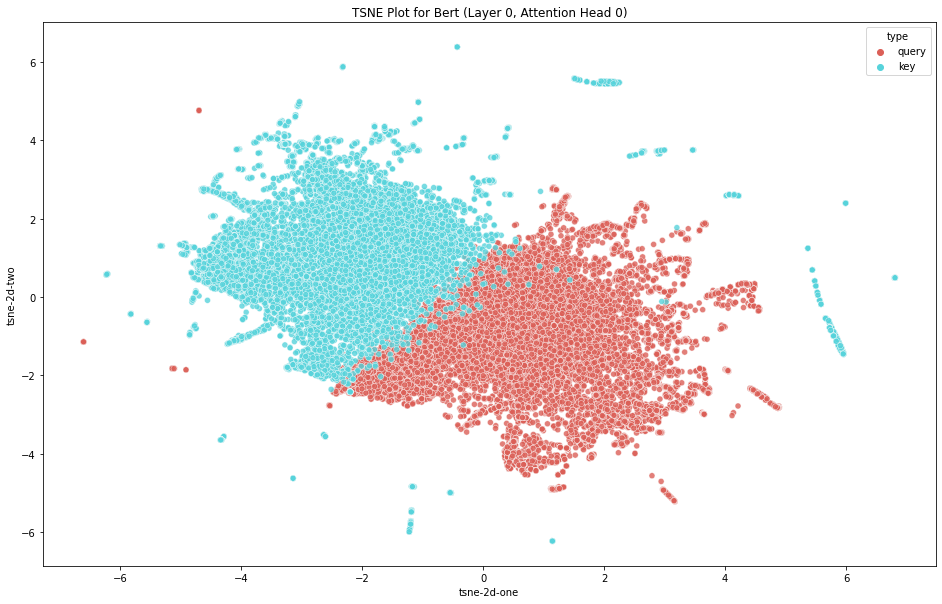

In [39]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="type",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.8
)
plt.title("TSNE Plot for Bert (Layer 0, Attention Head " + str(head) + ")")